# Demonstration of LBNL's work with clustering simulations and its applicability to FITS data.

To start an environment and download the dependencies for this notebook:

conda create -n mlccd_demo ipython jupyter python
conda activate mlccd_demo
pip install -r requirements.txt

These may matchup with the current repo environment, and eventually will be rolled into the requirements. 

# Dependencies used to examine FITS data and cluster

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, ndimage
import os
from scipy.signal import convolve2d
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib.colors import LogNorm
import concurrent.futures


This is an adapted demonstration from the LBNL's work on the MLCCD Diffusion repository. 

The lab uses these values for converting energy to keV presumably based on how many analog to digital converters there are that gathered the FITS data, will need more information specifically on the width and converters designed in the CCD deployment. 

In [6]:
# This will depend on the calibration and the deployment of the device to get accurate results!

keVperADC_guillermo = 1.02857e-5 ### 0.0036 keV per electron / 350 ADC per electron =
ped_width_guillermo = 1400 # ADC channels

# Load FITS files into an array and plot

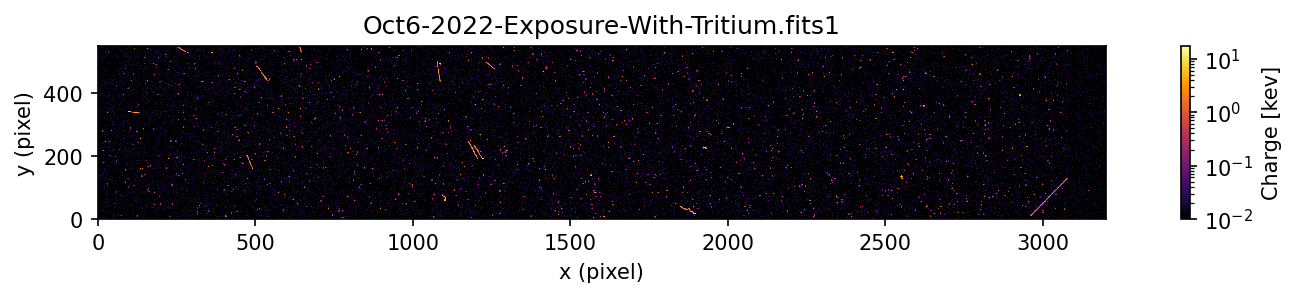

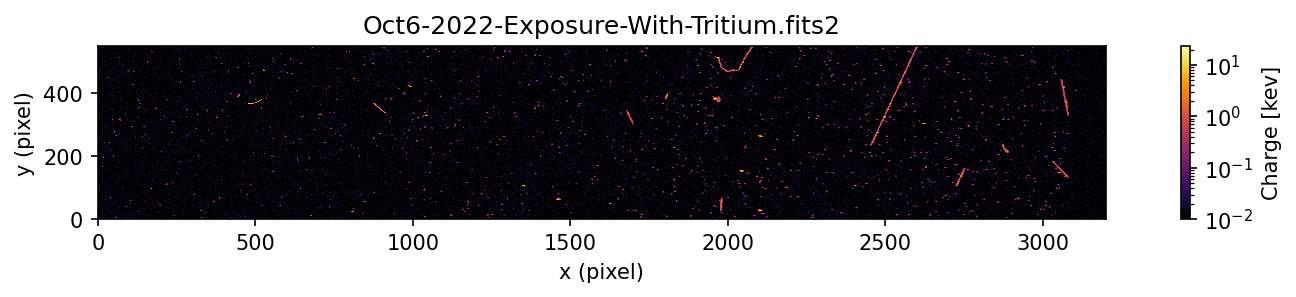

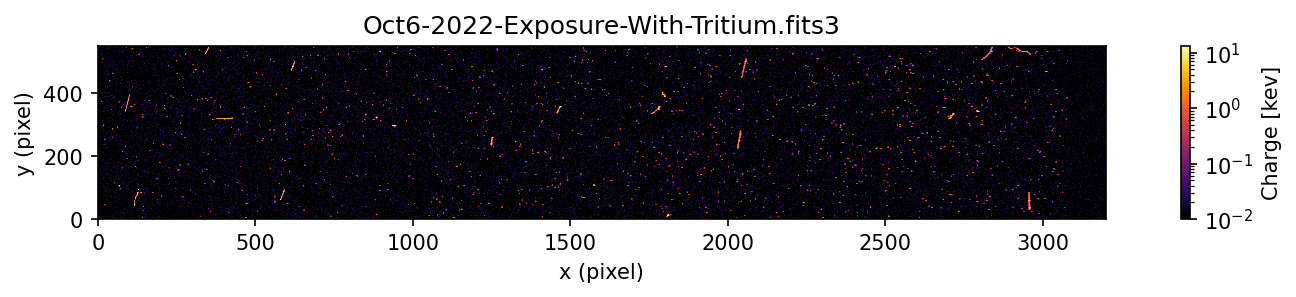

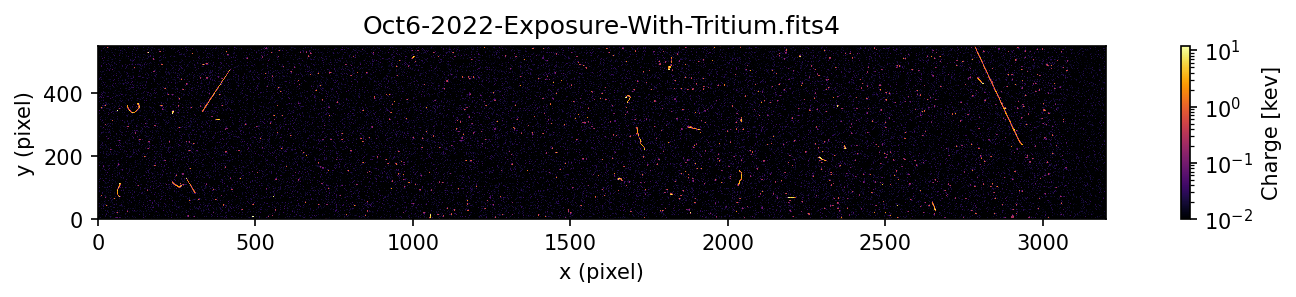

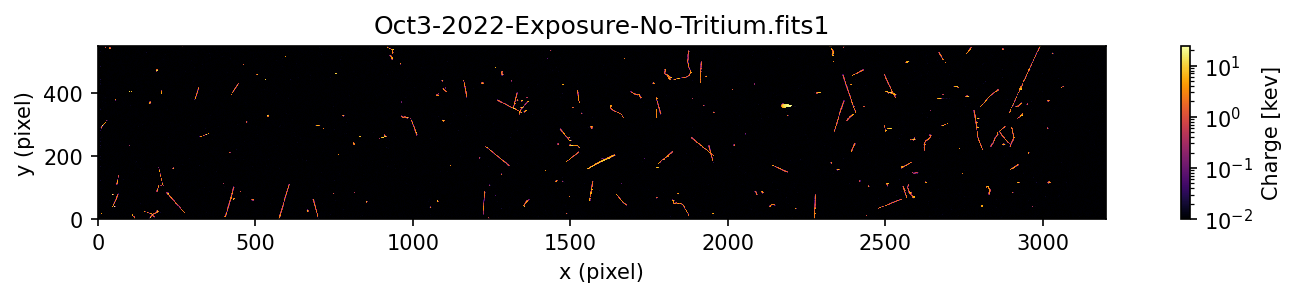

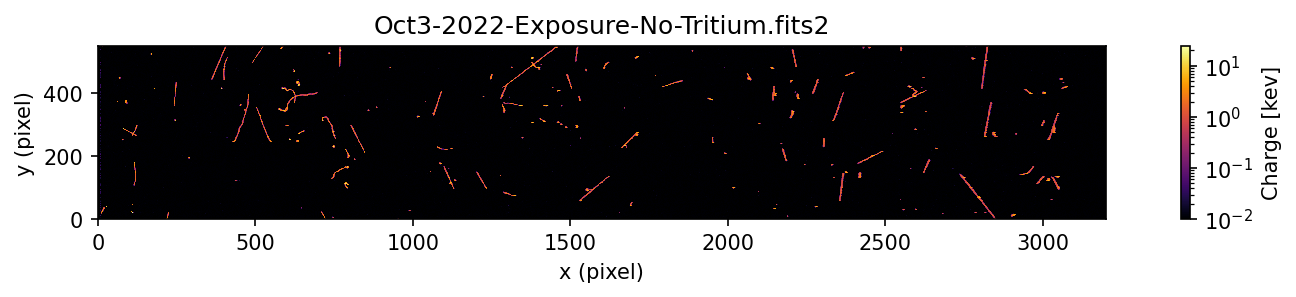

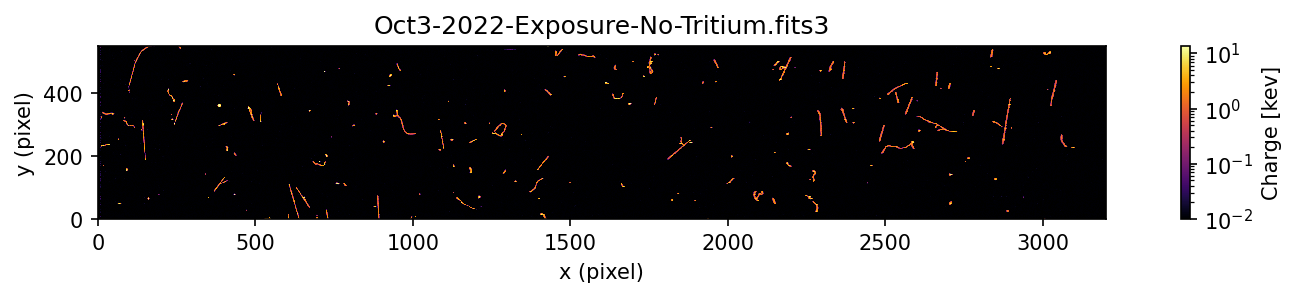

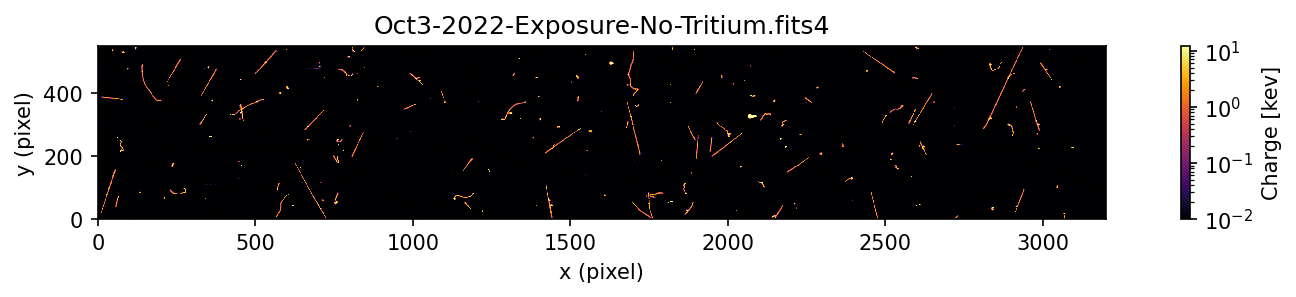

In [3]:
file_dir = os.getcwd() + "/fits_files/" # demonstration file location
files = [file for file in os.listdir(file_dir)] # add all FITS files to file array to open

# In the lab's demonstrations, they restrict the quadrants gathered from the FITS files to [0,3] signaling
# some possible issue with the CCD charge value gathering, for this demo we'll iterate through all of them.

# This is only included to remind of that limitation to ask about
quadrants = [0,3]

# Open FITS files and gather data from each HDU (Header Data Unit) present in each
datas = []
titles = []
for file in files:
    with fits.open(file_dir + file) as HDUs:
        hdu_count = 0
        for hdu in HDUs:
            datas.append(hdu.data)
            hdu_count += 1
            titles.append(file + str(hdu_count))

# Iterate over each HDU added to data and create graph for each with charge bar
# adapted function from their notebook work
for data, label in zip([data for data in datas], [title for title in titles]):
# Base subplots option, smaller resolution to fit in notebook
    fig, ax = plt.subplots(figsize=(13, 1.5), dpi=150)
# Generate x and y coordinates from a meshgrid of data arrays, determines rows and columns
    X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
# Generate heatmap plot with data adjusted by keV scaling value and charges normalized
    im = ax.pcolormesh(X, Y, data*keVperADC_guillermo, cmap='inferno', norm=LogNorm(vmin=1e-2))
    ax.set_facecolor('black')
    fig.colorbar(im, ax=ax, label='Charge [kev]')
    ax.set_aspect('equal')
    ax.set_xlabel('x (pixel)')
    ax.set_ylabel('y (pixel)')
    ax.set_title(label)

# Attempt clusterization of points of interest

<>:102: SyntaxWarning: invalid escape sequence '\s'
<>:102: SyntaxWarning: invalid escape sequence '\s'
<>:102: SyntaxWarning: invalid escape sequence '\s'
<>:102: SyntaxWarning: invalid escape sequence '\s'
/var/folders/kc/pzfpsdt55h3cn6p36x_gyp1r0000gn/T/ipykernel_27896/3238979794.py:102: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f'Measured id:{i}, $\sigma_x$: {sigma_x:.2f}, $\sigma_y$: {sigma_y:.2f}, E: {np.sum(cluster_image)*keVperADC_guillermo:.2f}keV')
/var/folders/kc/pzfpsdt55h3cn6p36x_gyp1r0000gn/T/ipykernel_27896/3238979794.py:102: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f'Measured id:{i}, $\sigma_x$: {sigma_x:.2f}, $\sigma_y$: {sigma_y:.2f}, E: {np.sum(cluster_image)*keVperADC_guillermo:.2f}keV')
/var/folders/kc/pzfpsdt55h3cn6p36x_gyp1r0000gn/T/ipykernel_27896/3238979794.py:11: RuntimeWarning: invalid value encountered in sqrt
  sigma_y = np.sqrt(np.sum(dtrack * (y - mean_y)**2) / sum_weights)
/var/folders/kc/pzfpsdt55h3cn6p36x_gyp1r0000gn/

Maximum cluster energy in exposures: 2001.5147705078125 keV
Minimum cluster energy in exposures: 1.0017281770706177 keV
Average cluster energy in exposures: 17.155323028564453 keV
Number of clusters: 1060
Processed Oct6-2022-Exposure-With-Tritium.fits4
Maximum cluster energy in exposures: 2025.5616455078125 keV
Minimum cluster energy in exposures: 1.0230069160461426 keV
Average cluster energy in exposures: 15.137539863586426 keV
Number of clusters: 1108
Processed Oct6-2022-Exposure-With-Tritium.fits2
Maximum cluster energy in exposures: 3945.30224609375 keV
Minimum cluster energy in exposures: 1.1727488040924072 keV
Average cluster energy in exposures: 224.78038024902344 keV
Number of clusters: 207
Processed Oct3-2022-Exposure-No-Tritium.fits1
Maximum cluster energy in exposures: 2188.54248046875 keV
Minimum cluster energy in exposures: 1.3472954034805298 keV
Average cluster energy in exposures: 215.81117248535156 keV
Number of clusters: 187
Processed Oct3-2022-Exposure-No-Tritium.fits

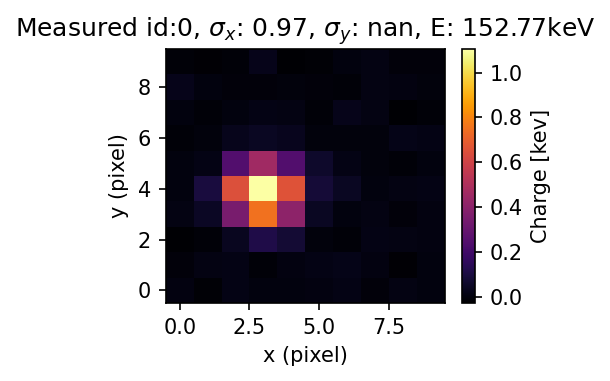

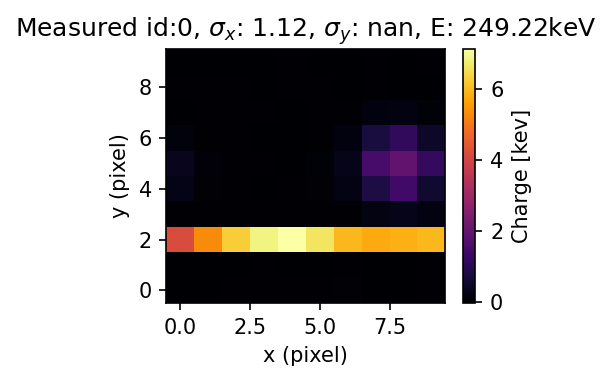

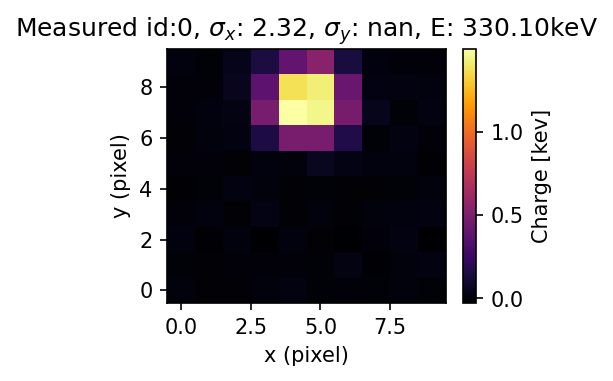

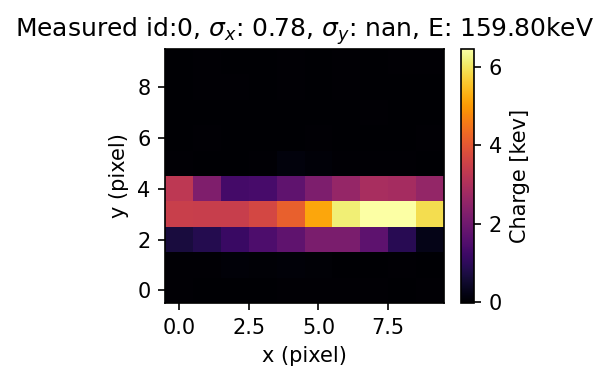

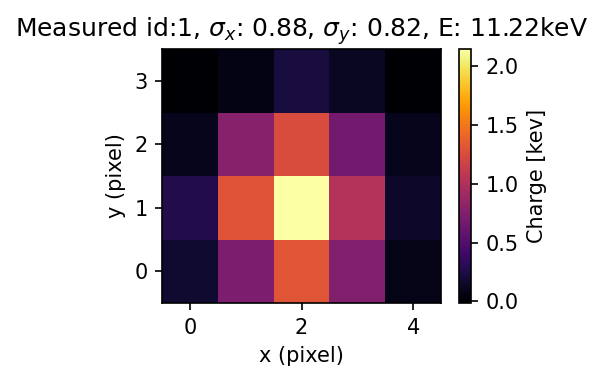

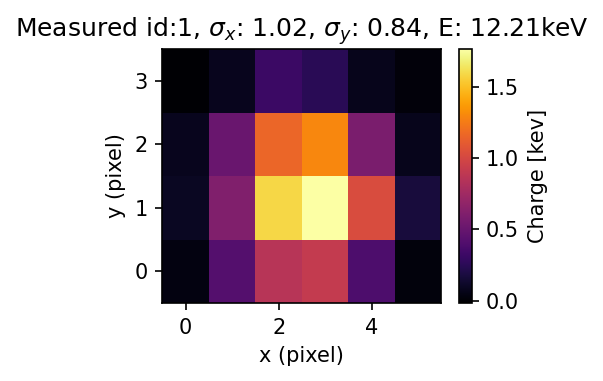

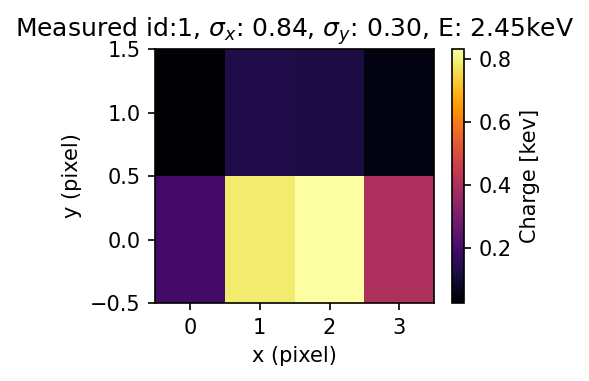

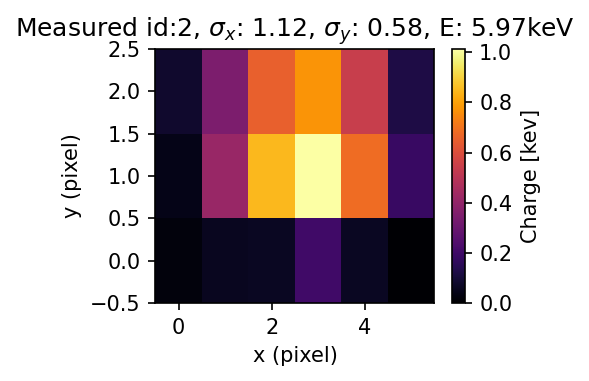

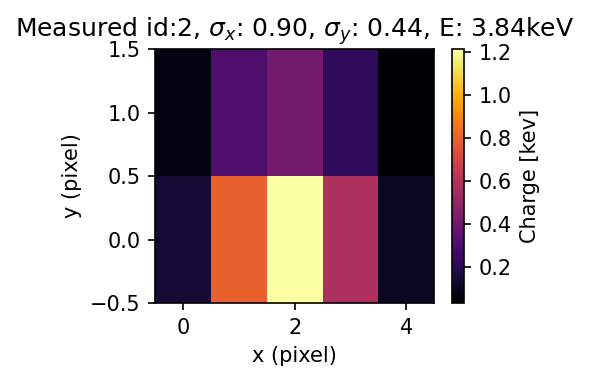

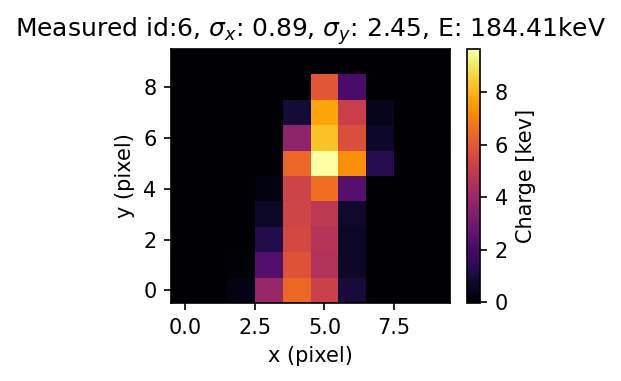

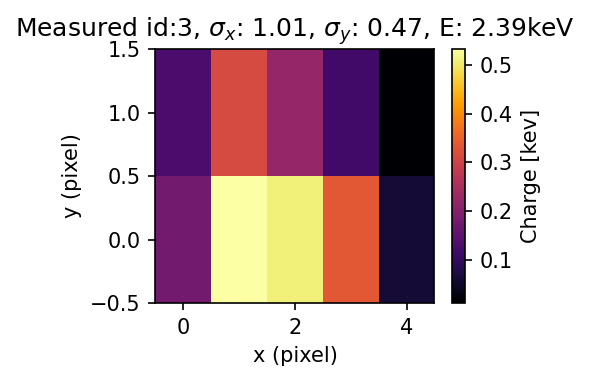

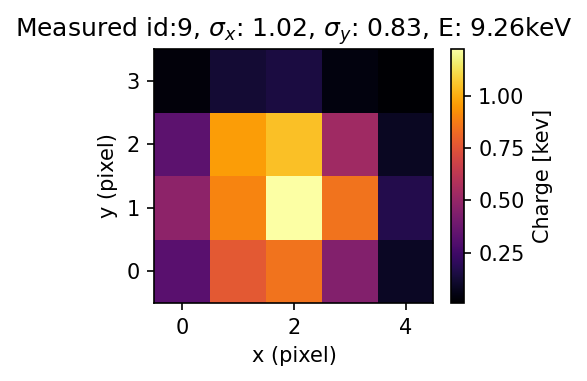

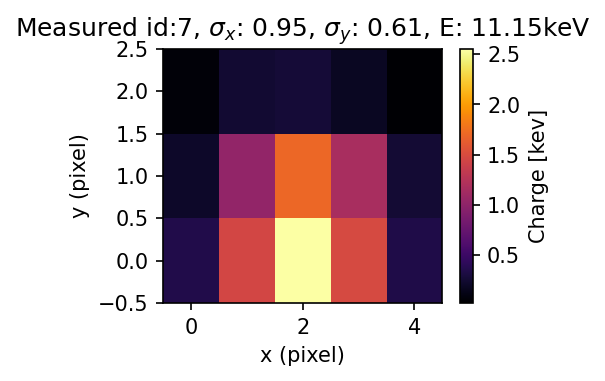

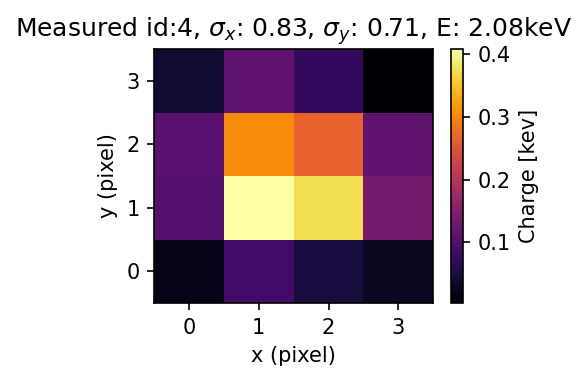

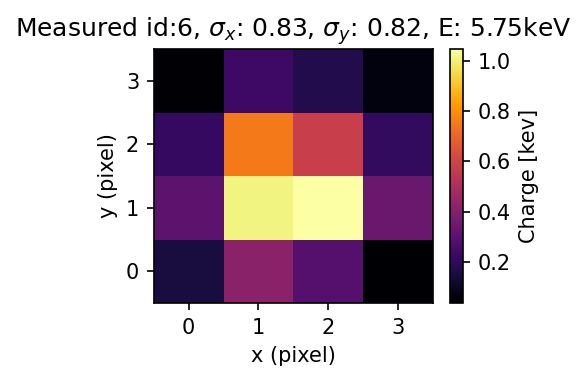

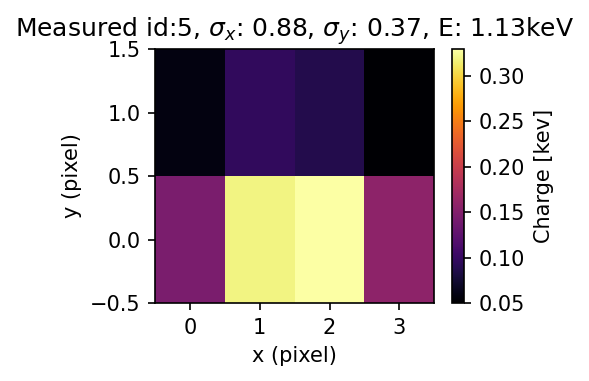

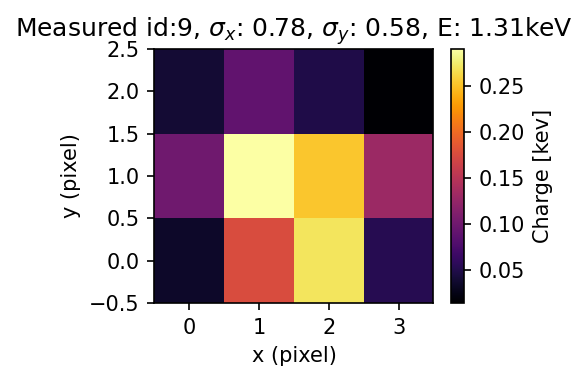

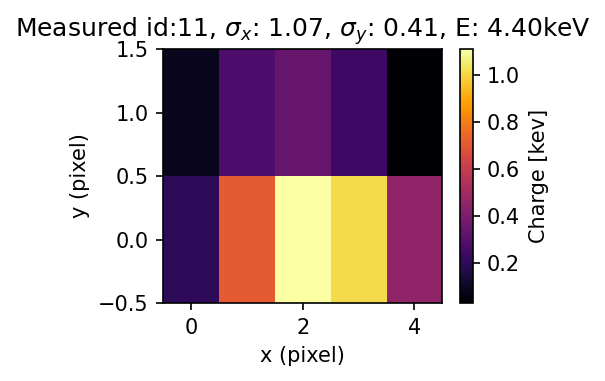

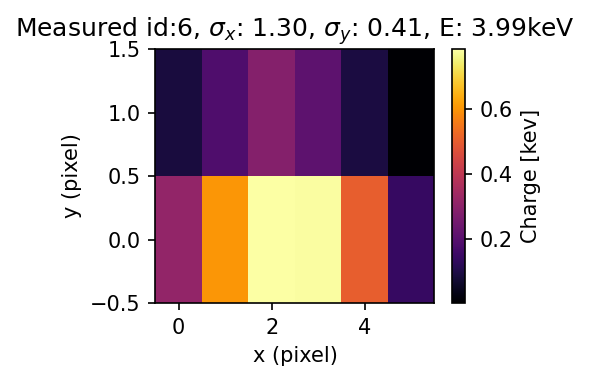

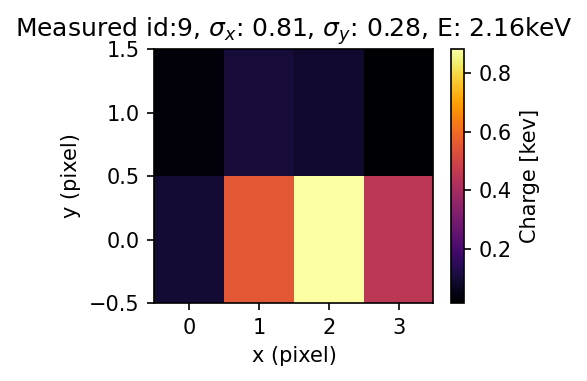

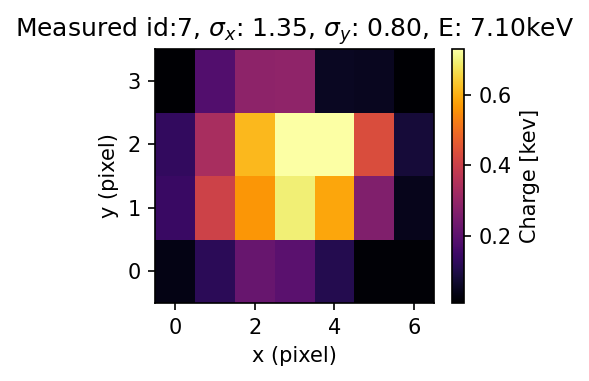

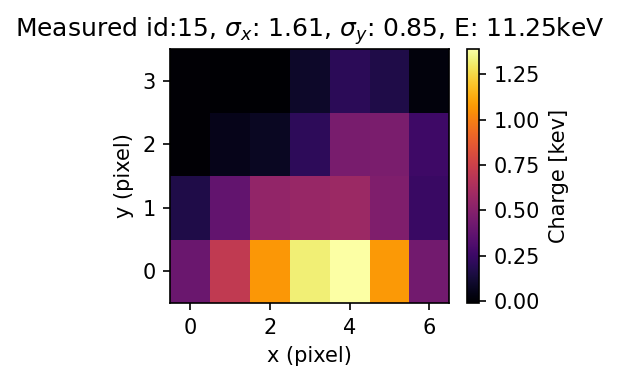

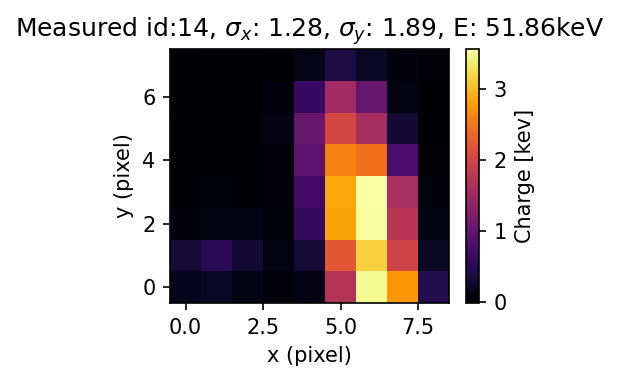

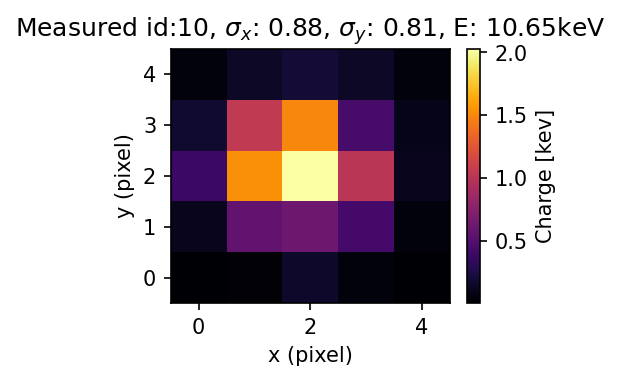

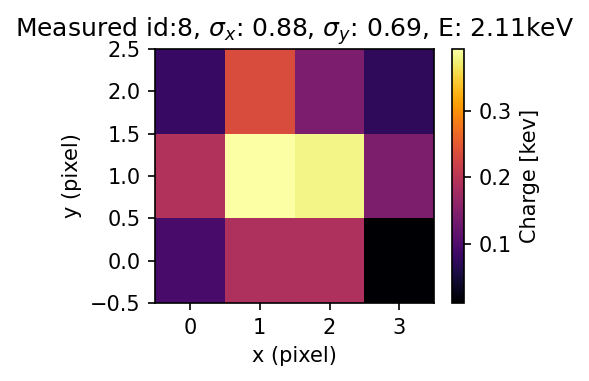

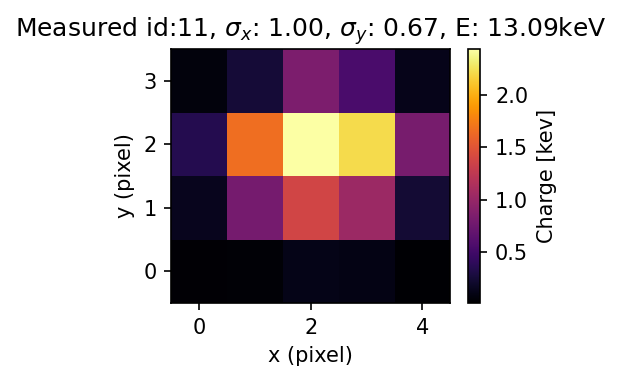

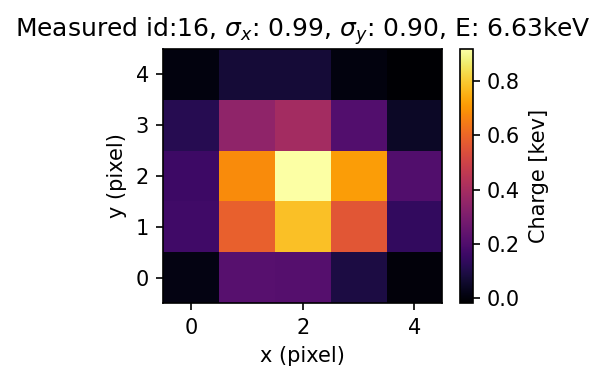

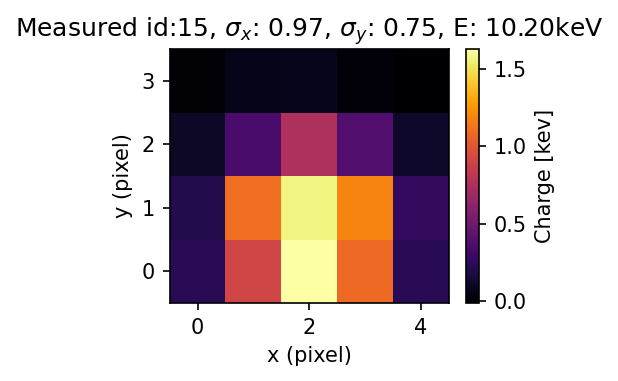

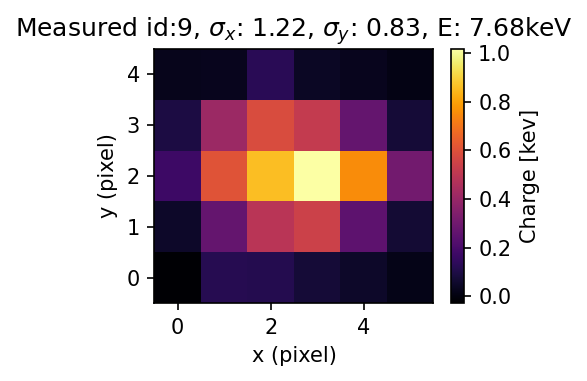

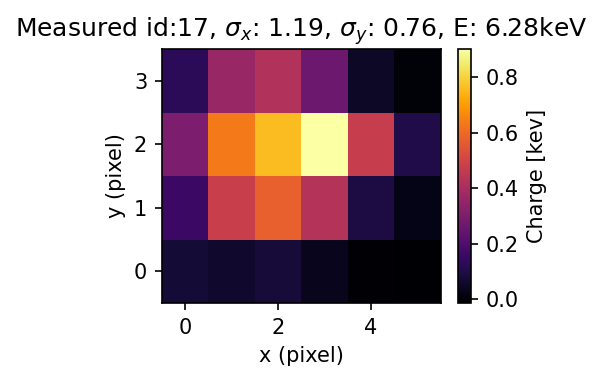

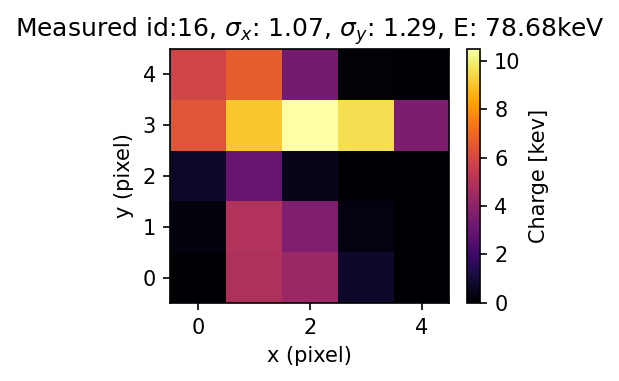

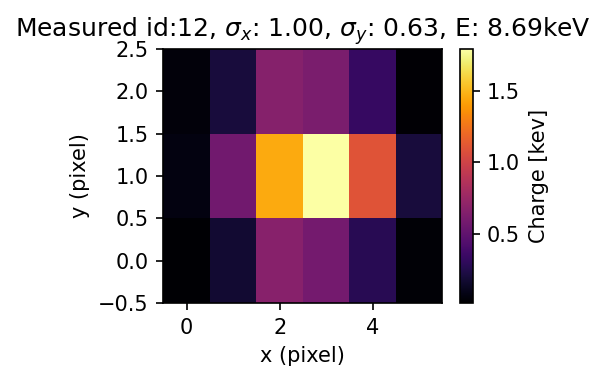

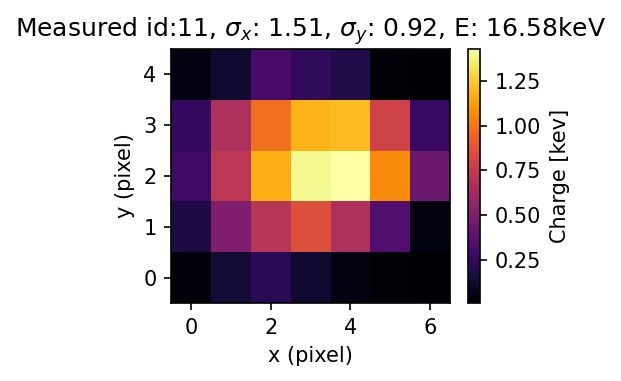

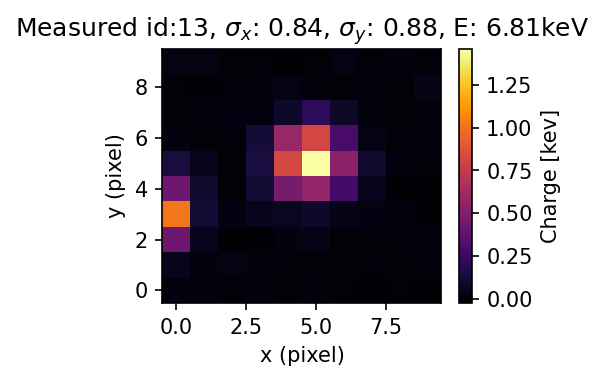

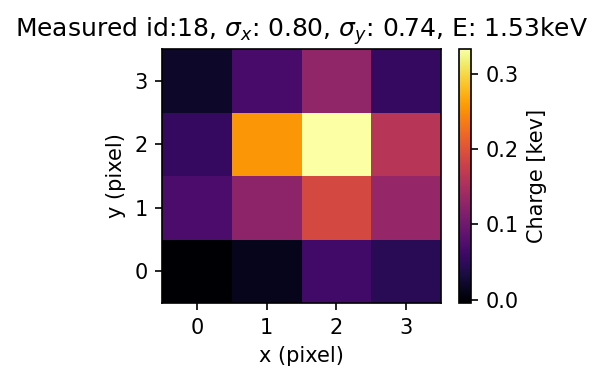

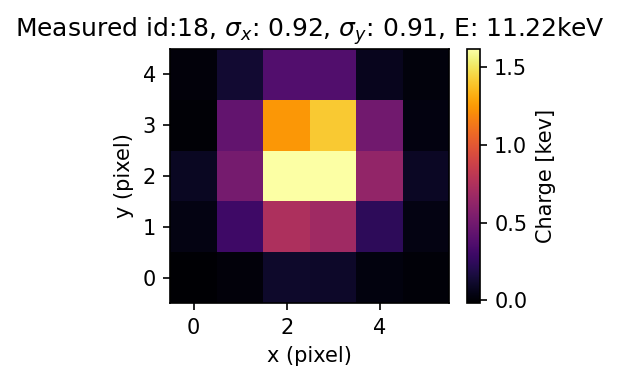

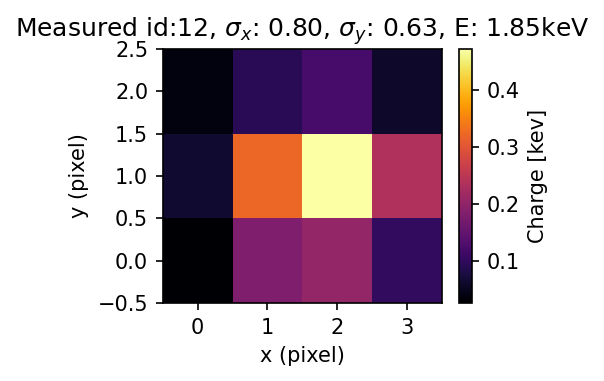

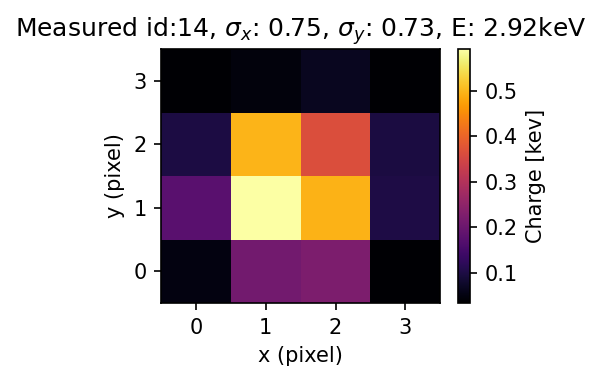

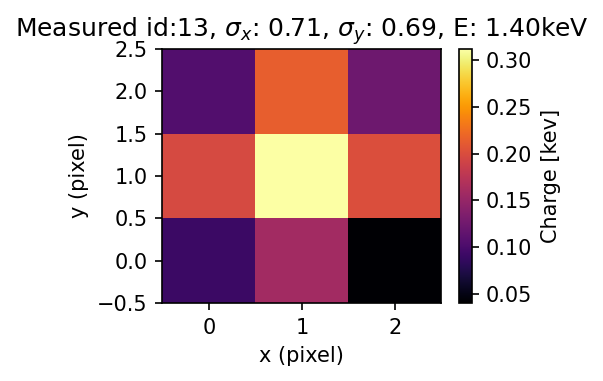

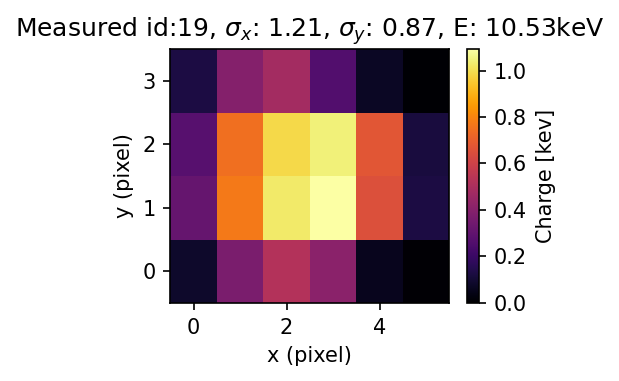

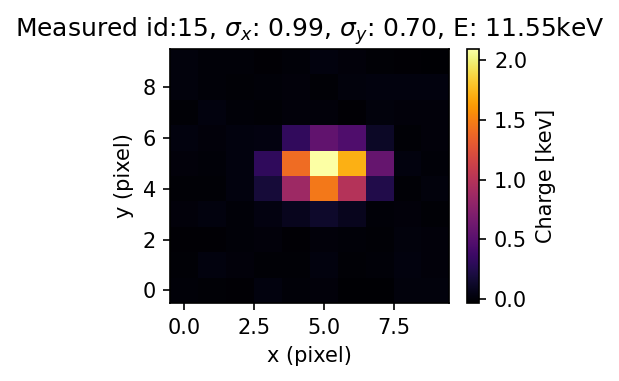

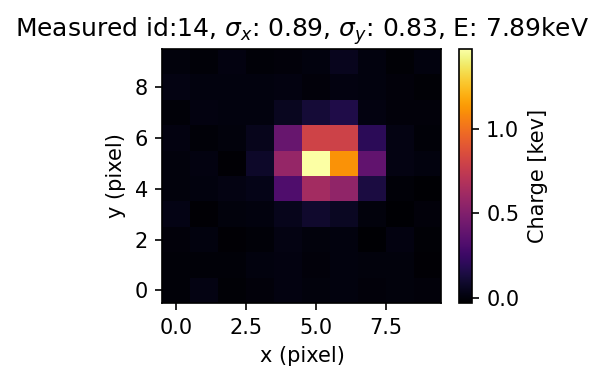

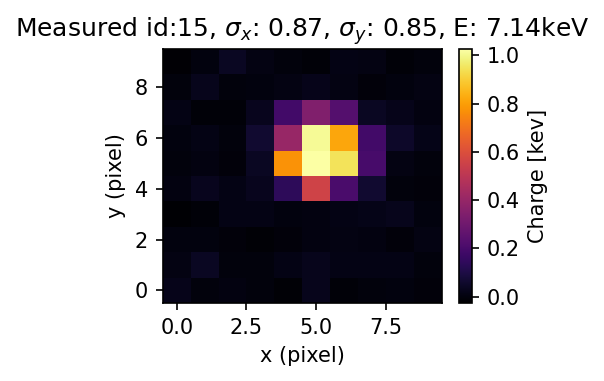

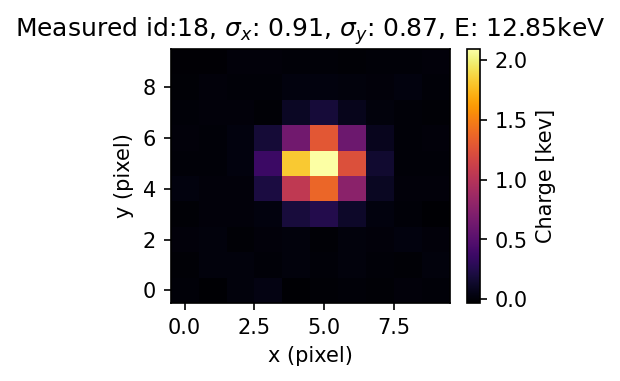

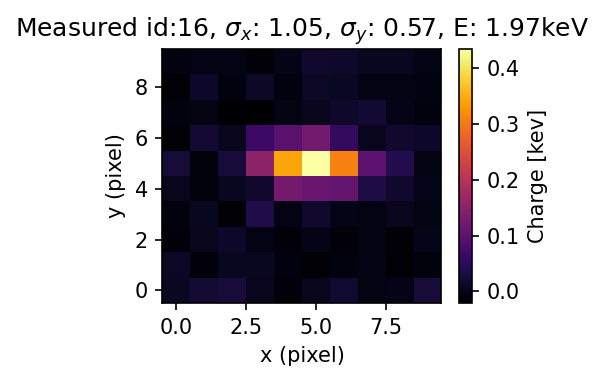

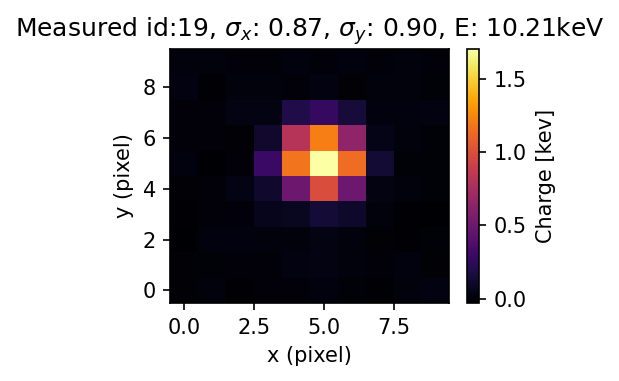

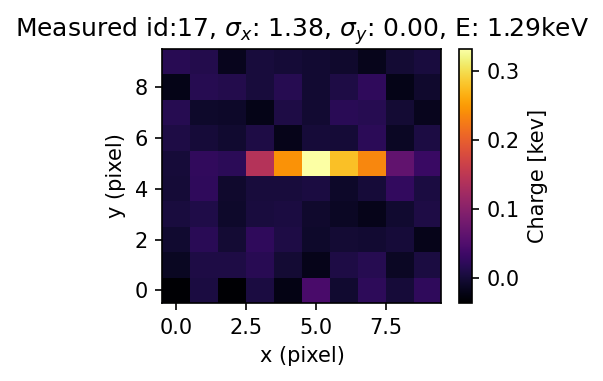

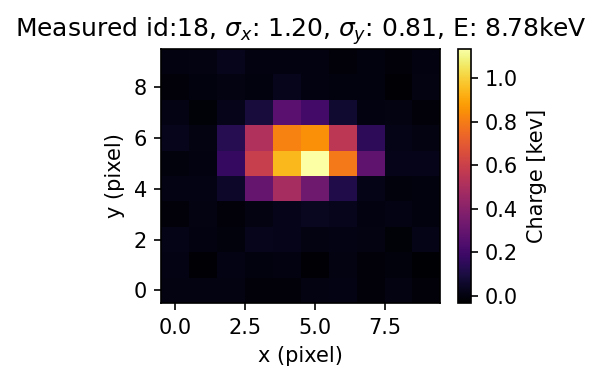

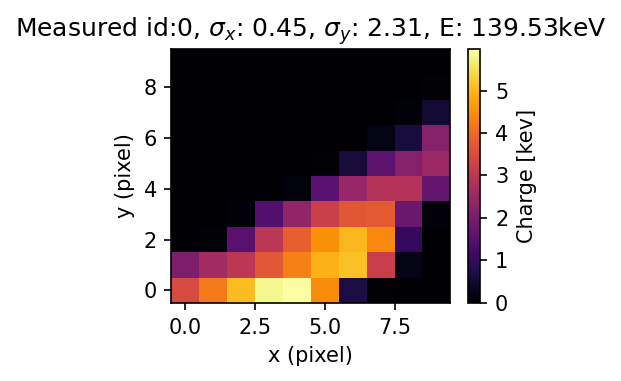

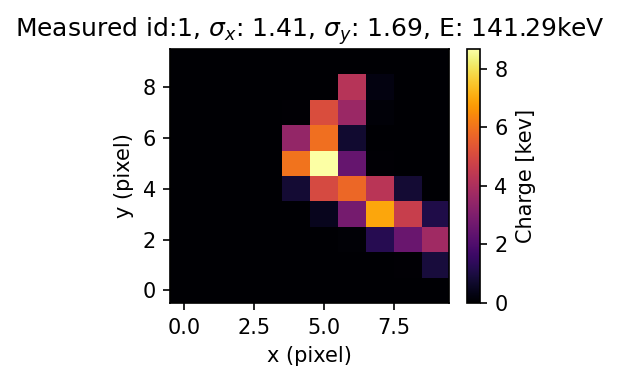

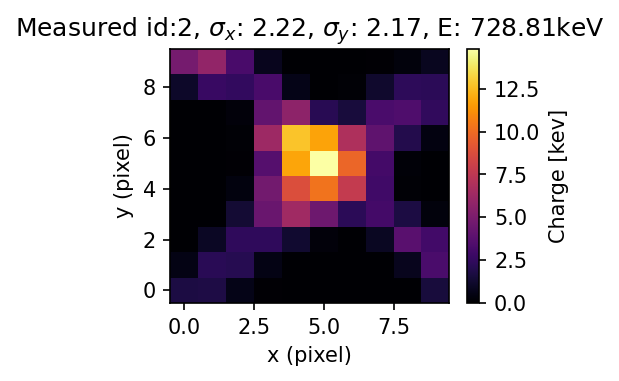

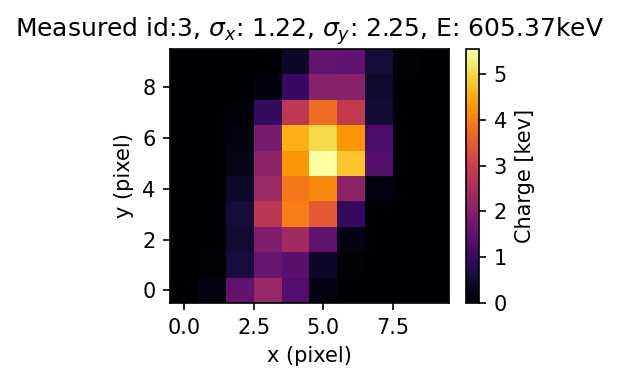

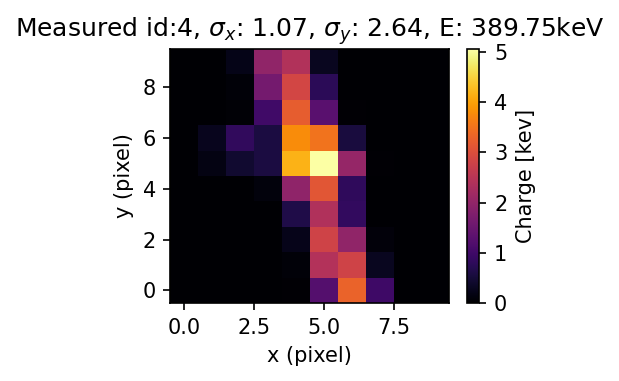

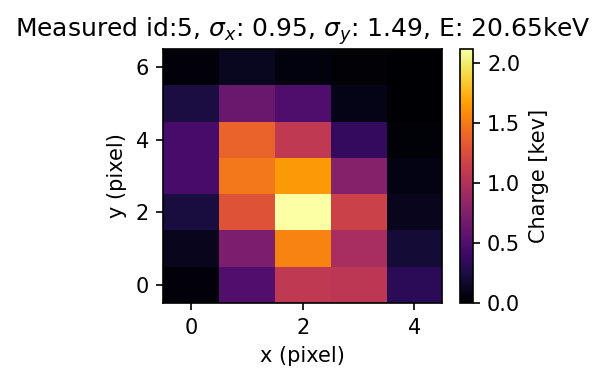

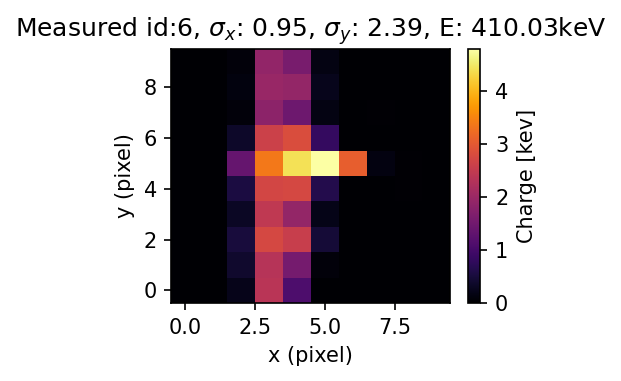

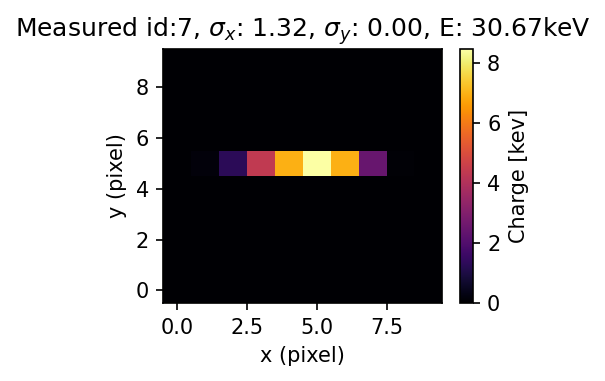

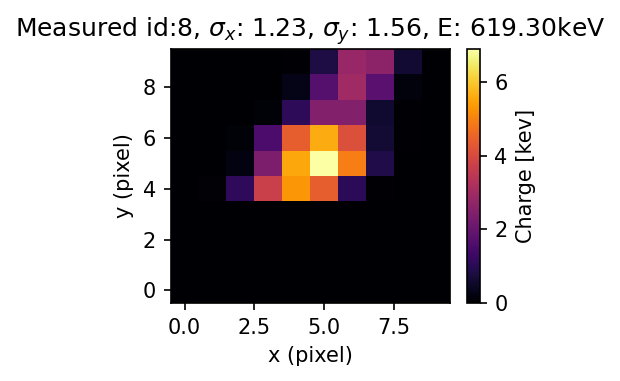

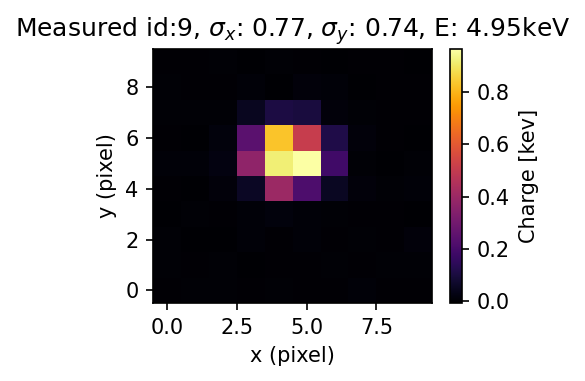

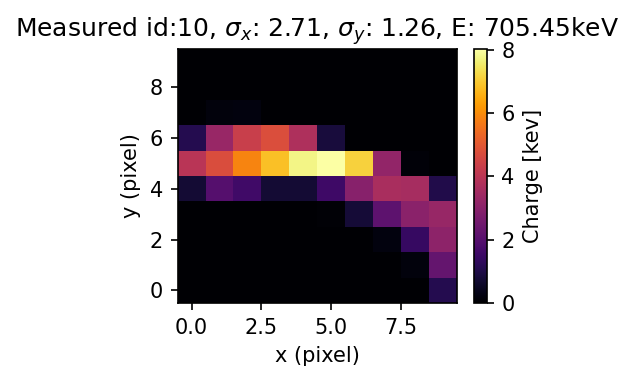

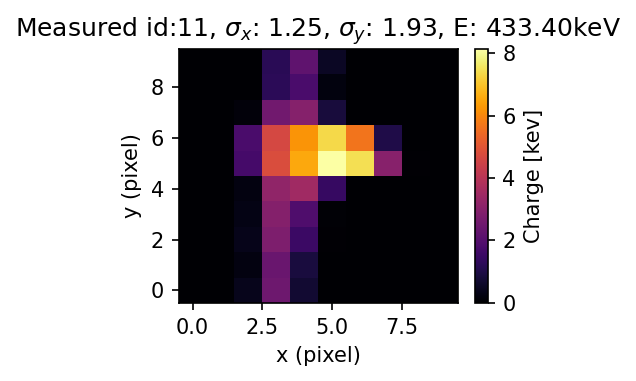

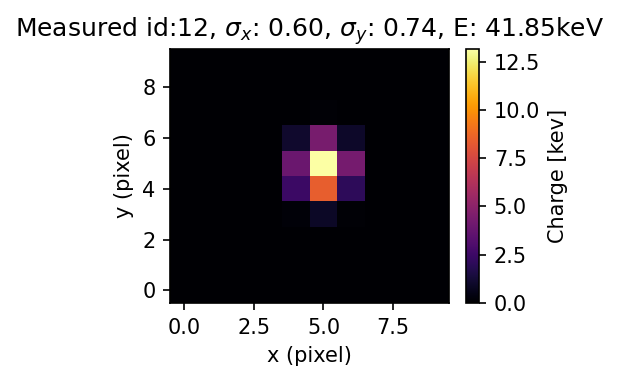

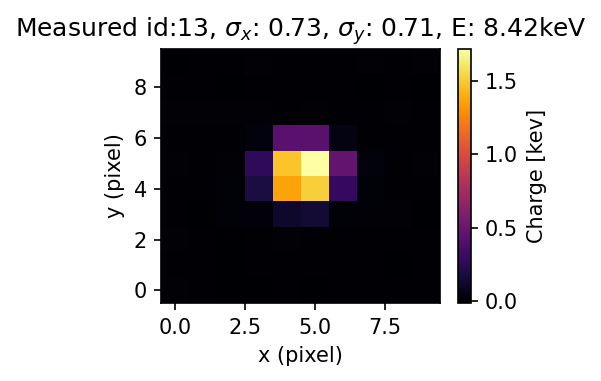

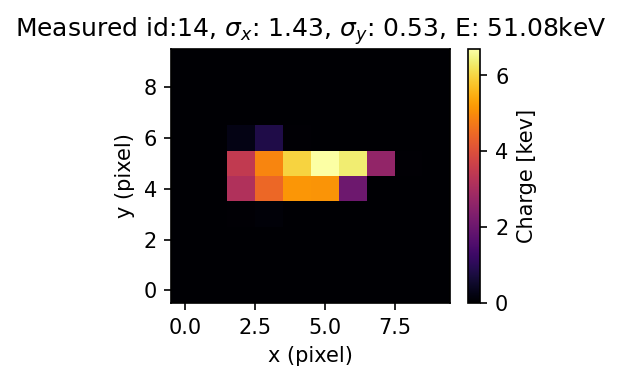

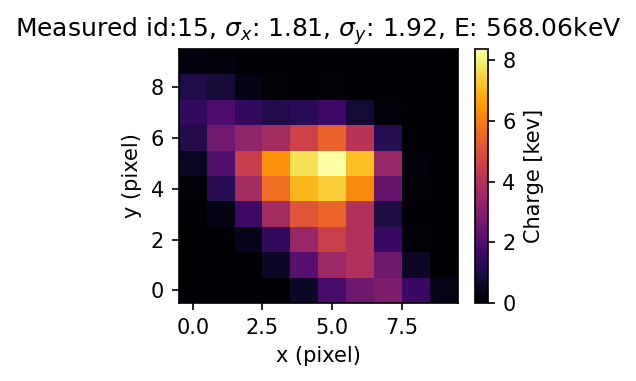

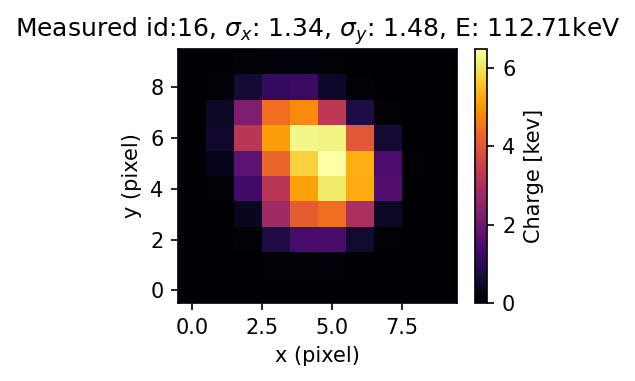

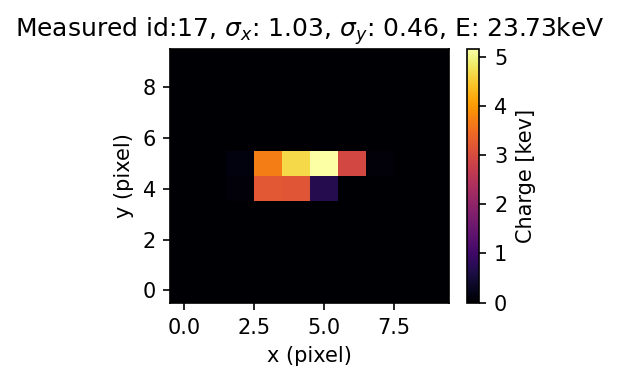

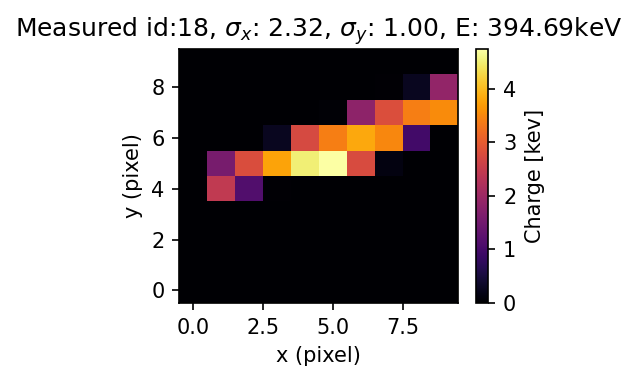

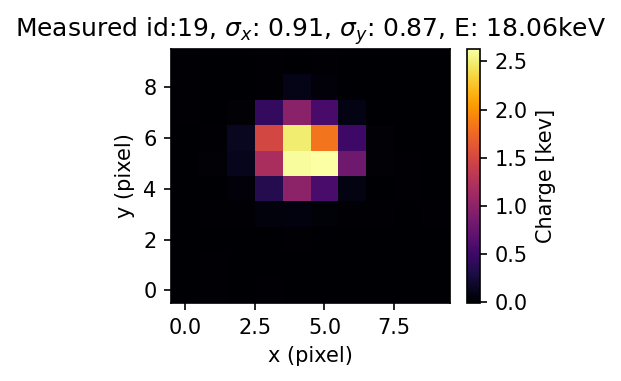

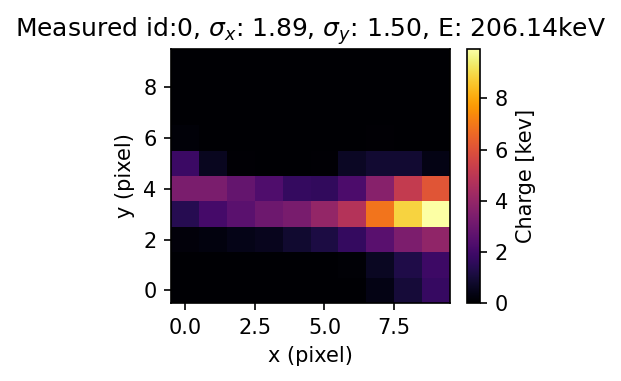

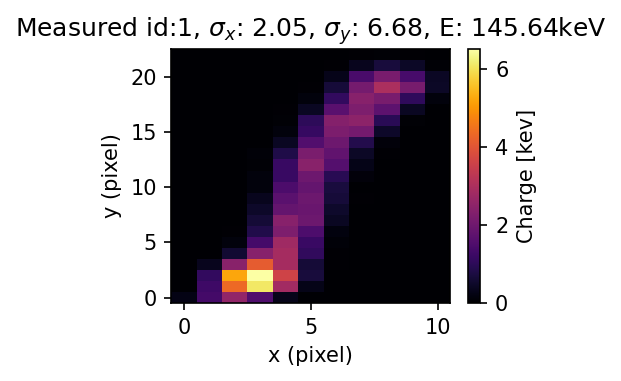

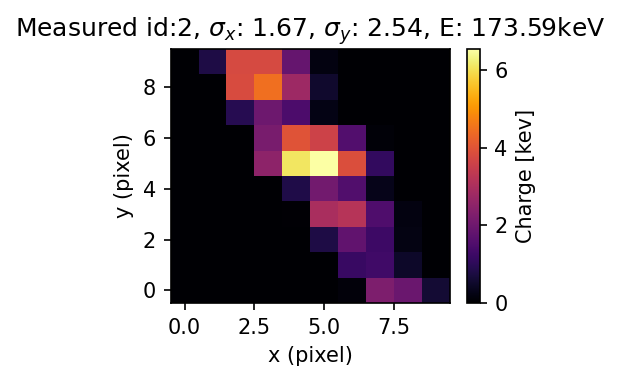

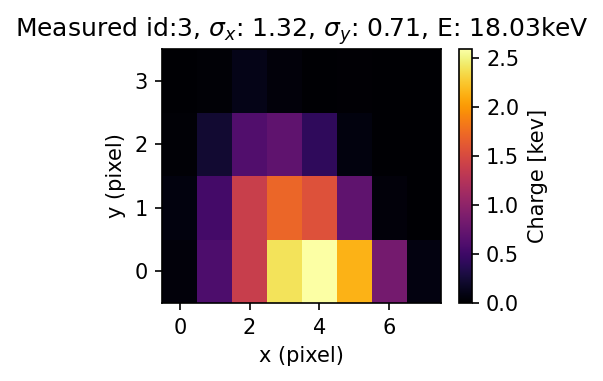

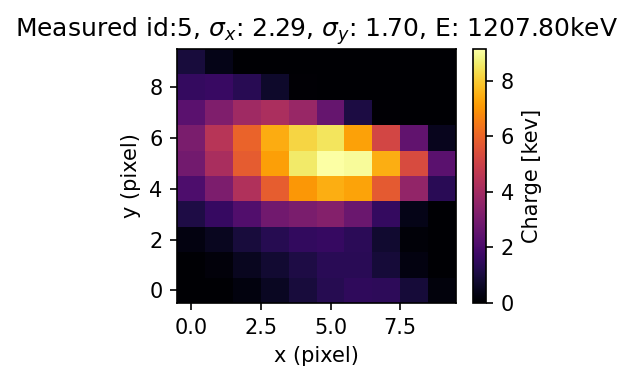

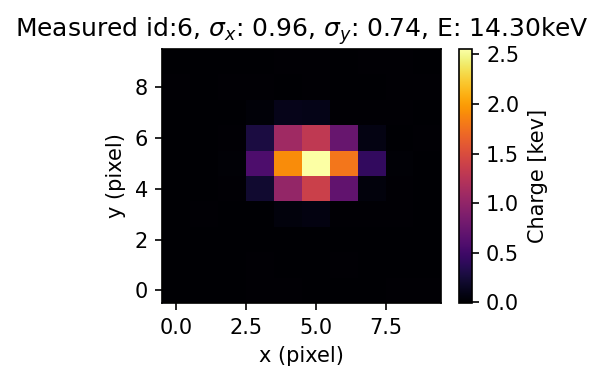

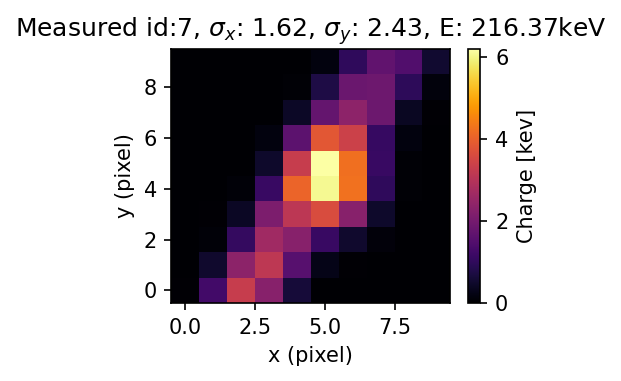

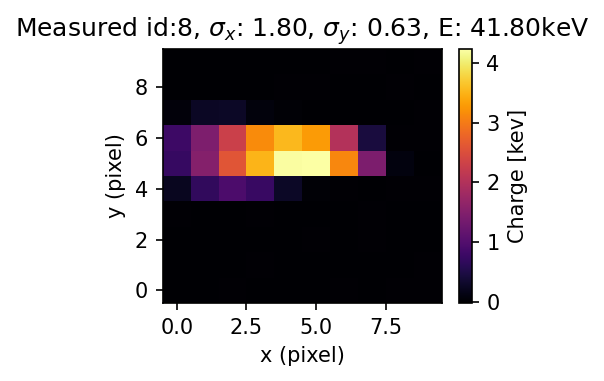

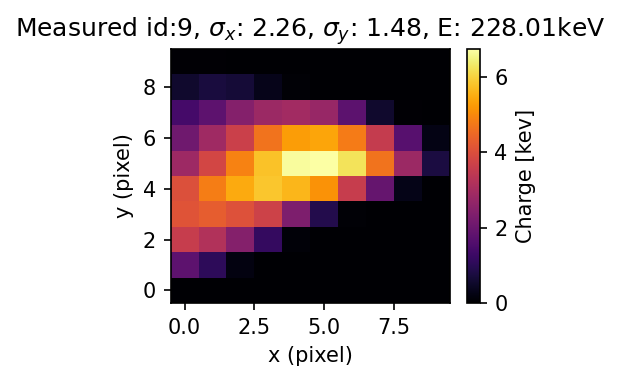

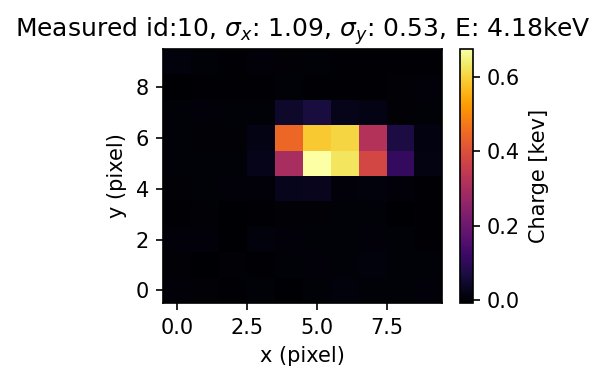

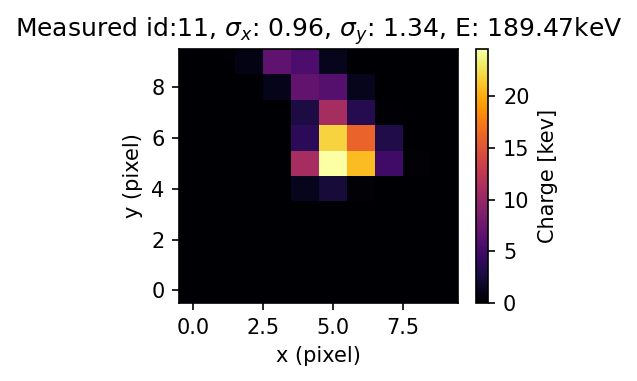

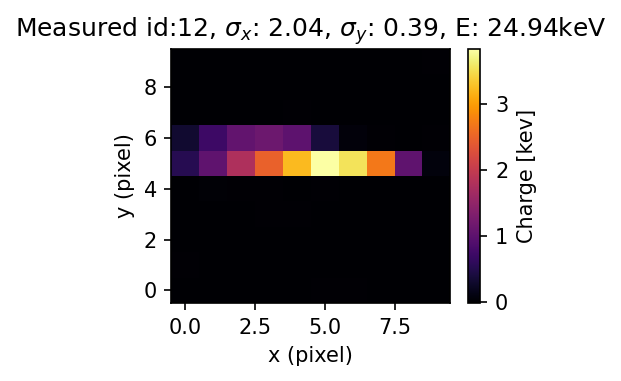

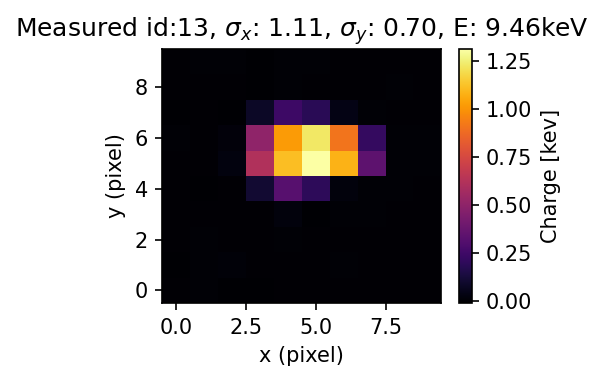

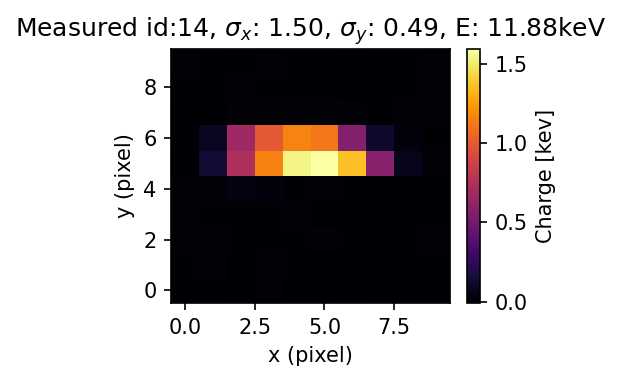

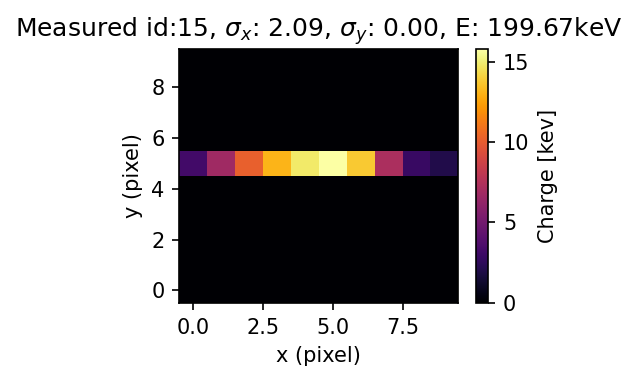

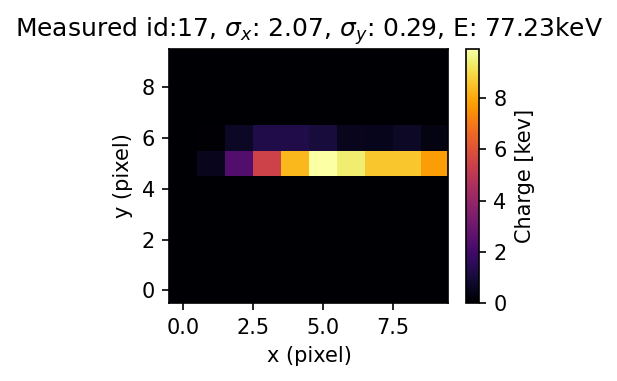

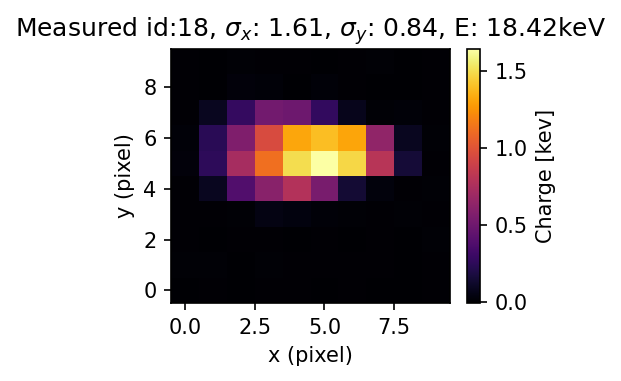

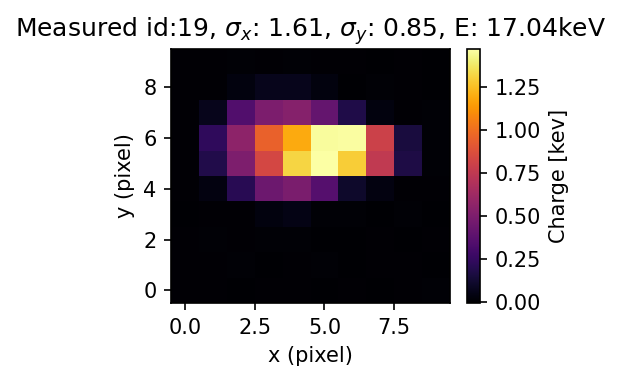

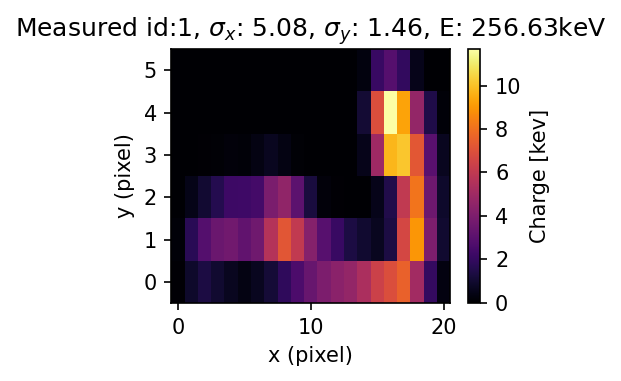

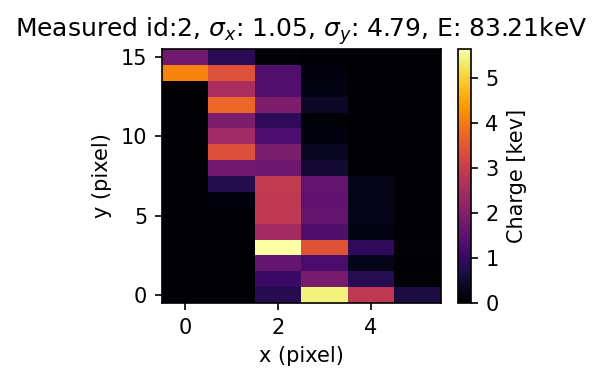

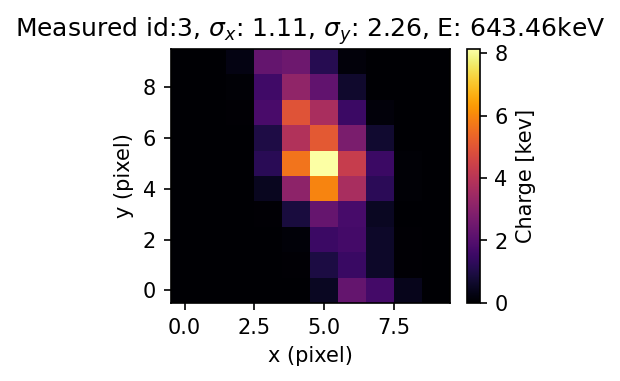

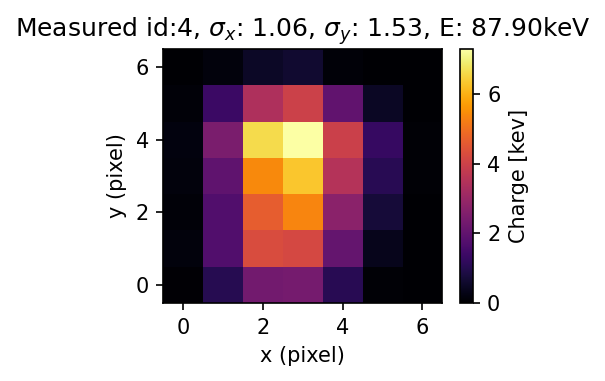

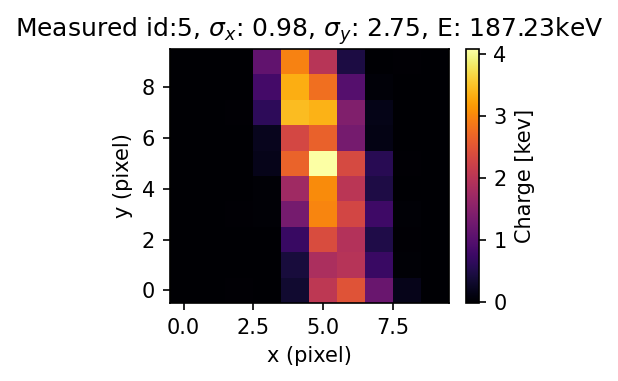

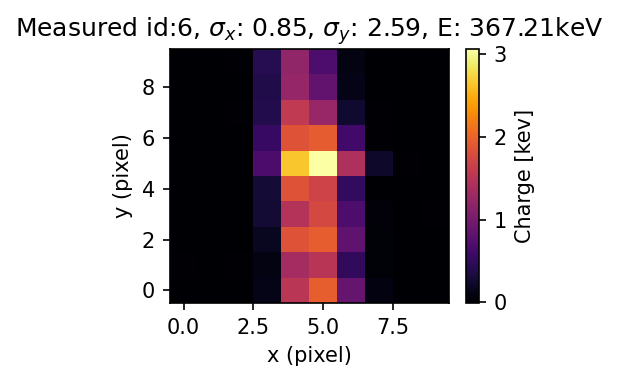

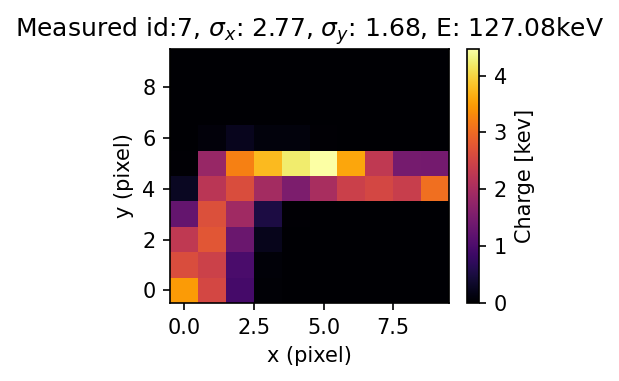

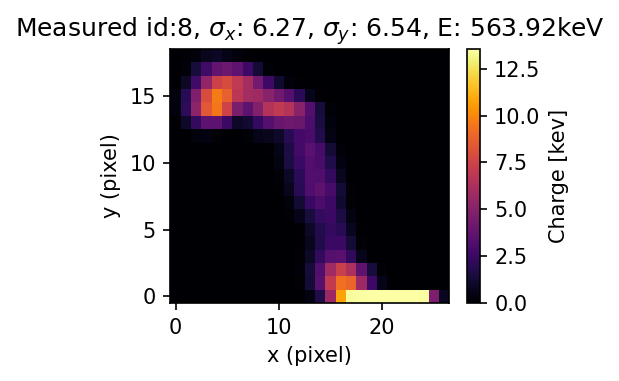

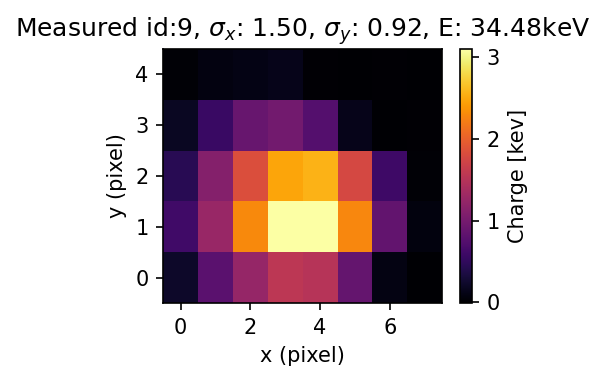

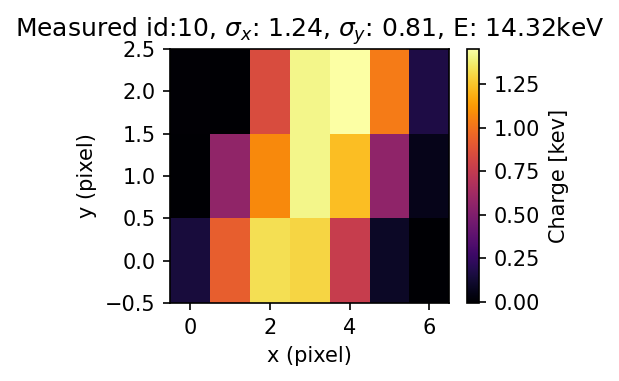

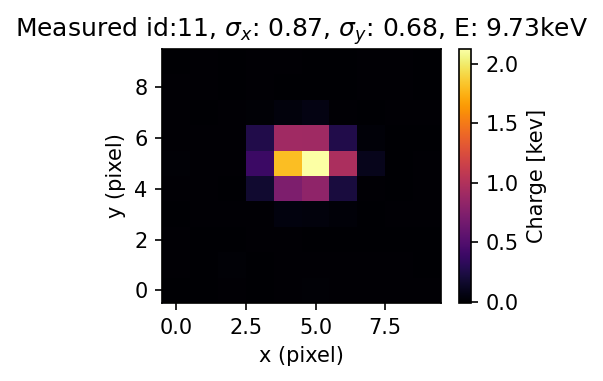

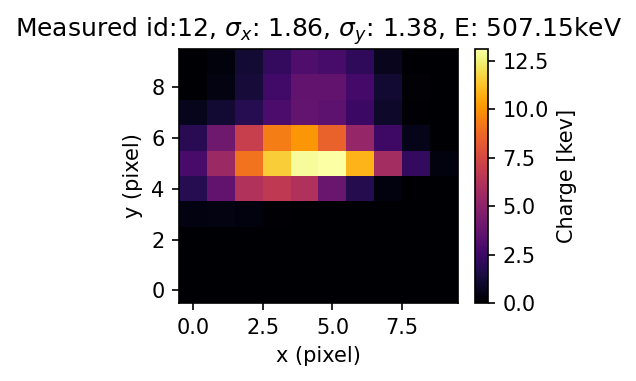

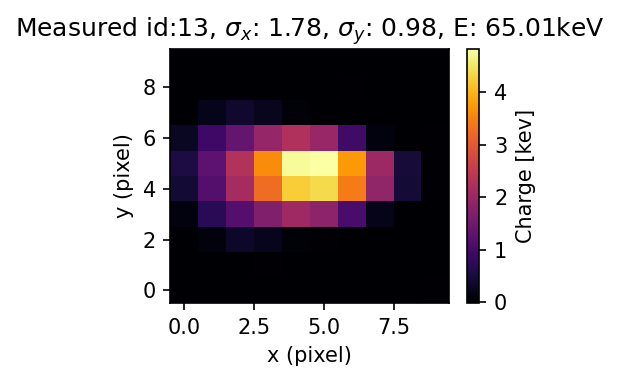

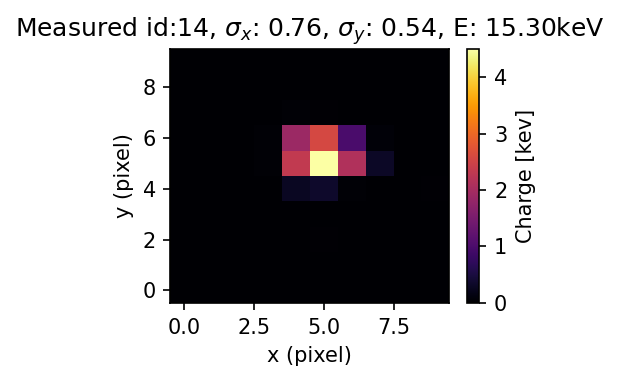

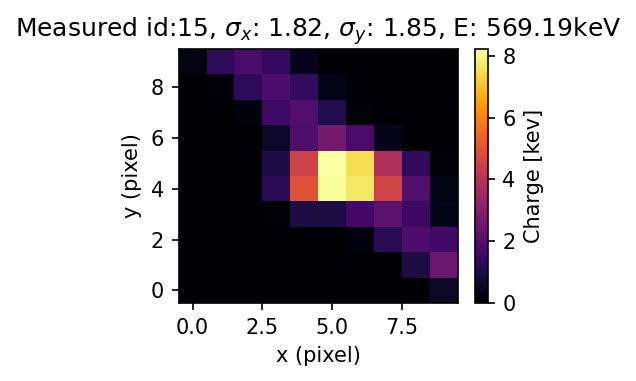

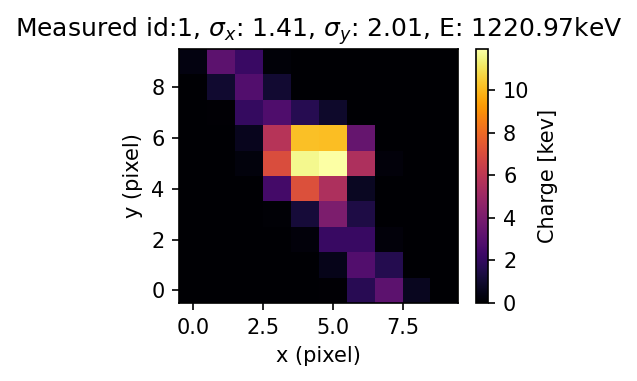

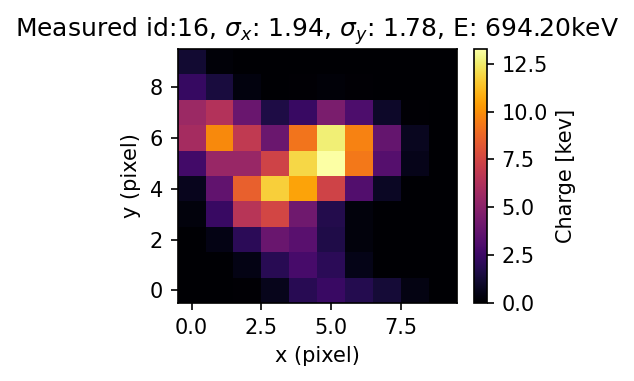

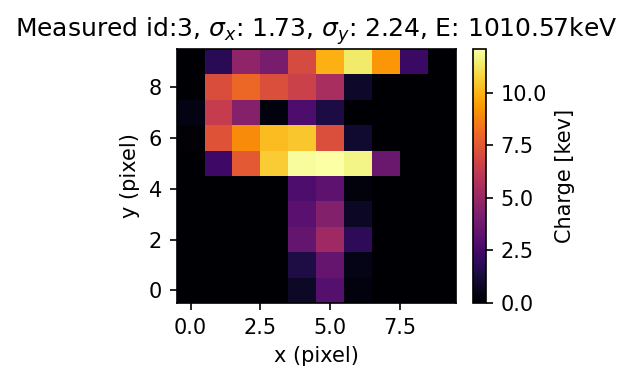

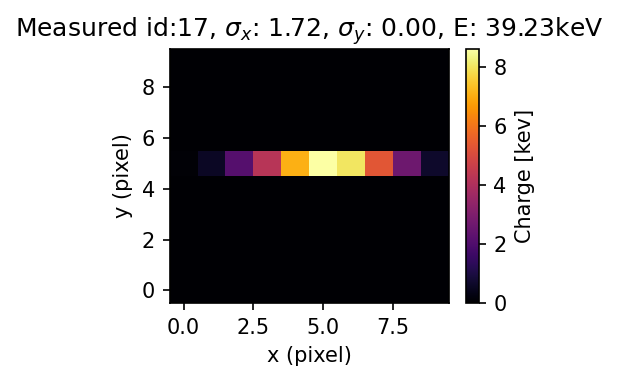

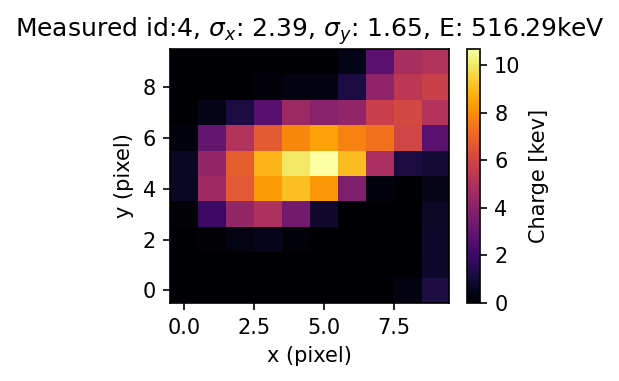

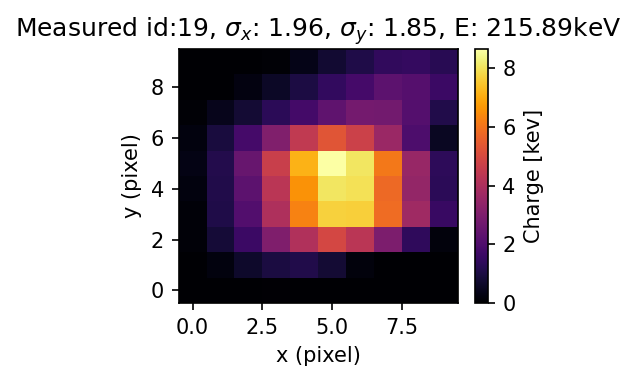

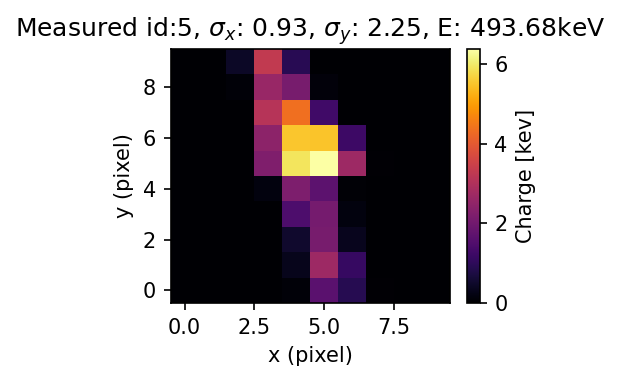

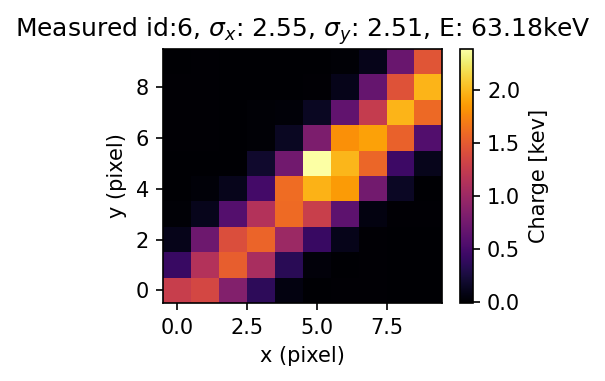

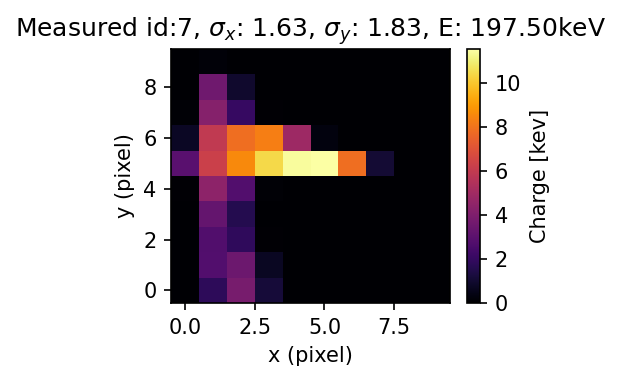

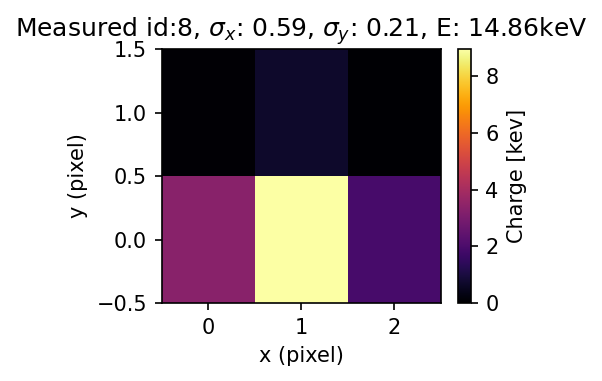

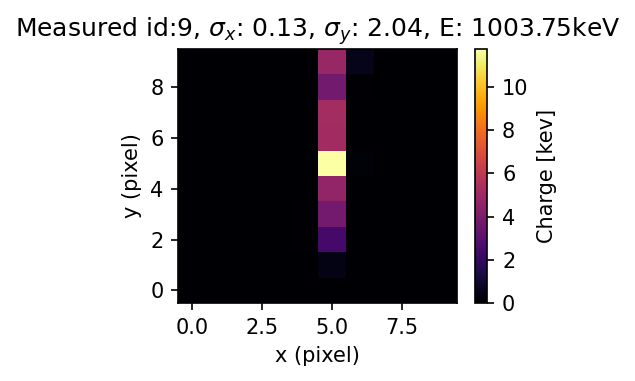

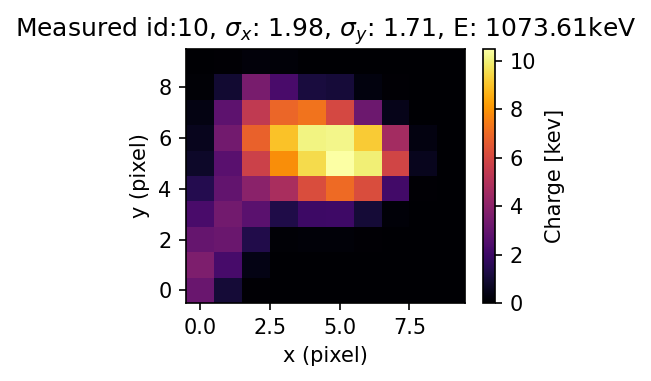

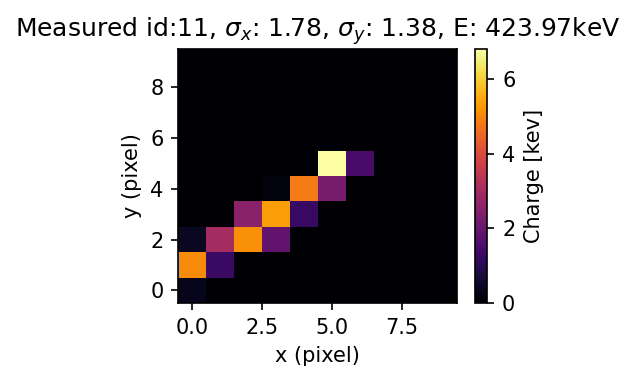

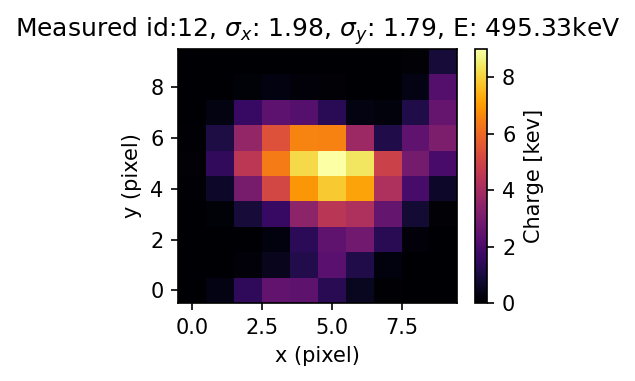

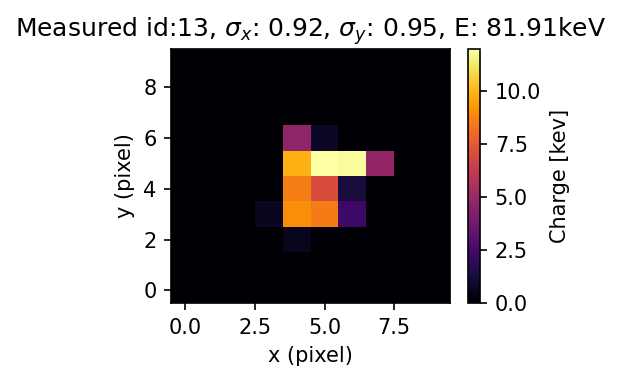

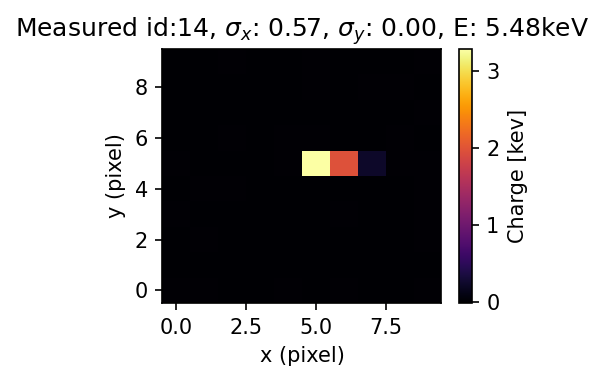

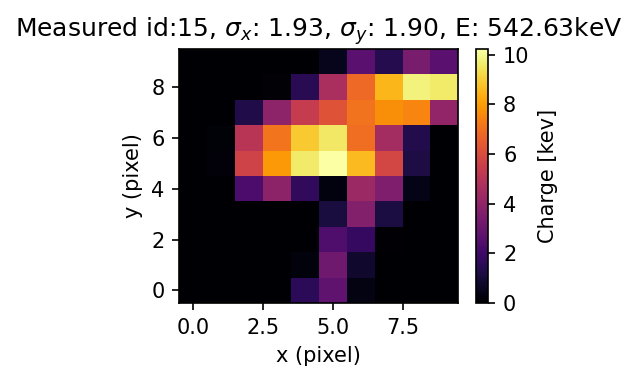

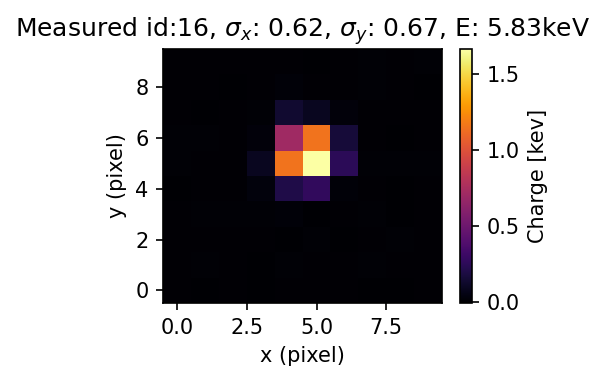

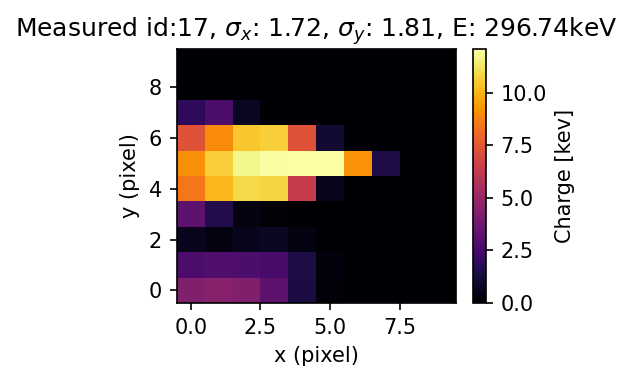

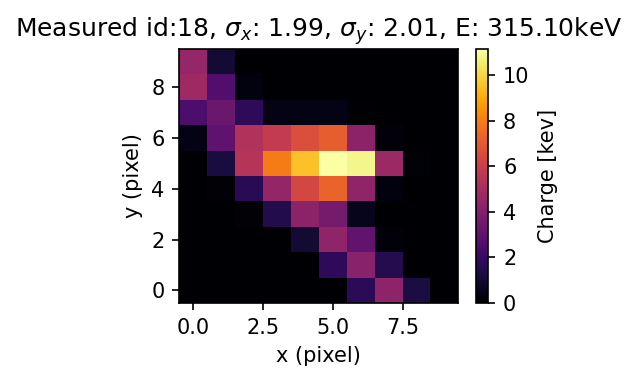

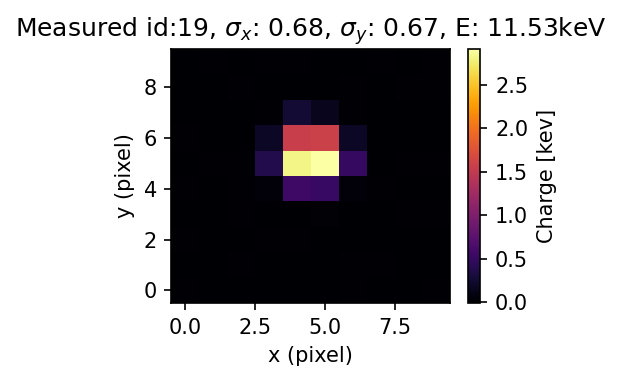

In [ ]:
# The lab used a 4 sigma threshold for determining points of interest from the background
foursig_threshold = 4 * ped_width_guillermo * keVperADC_guillermo

# Helper function that the lab used to calculate the standard deviation of a track of x and y
def calc_sigmas(dtrack):
    x, y = np.meshgrid(np.arange(dtrack.shape[1]), np.arange(dtrack.shape[0]))
    sum_weights = np.sum(dtrack)
    mean_x = np.sum(x * dtrack) / sum_weights
    mean_y = np.sum(y * dtrack) / sum_weights
    sigma_x = np.sqrt(np.sum(dtrack * (x - mean_x)**2) / sum_weights)
    sigma_y = np.sqrt(np.sum(dtrack * (y - mean_y)**2) / sum_weights)
    return sigma_x, sigma_y

from scipy.ndimage import label, maximum_position

# Iterate through each point of data in datas[0] as an example,
# Uses a widget to display progress of working through FITS data

# This could be used to parse individual HDUs with by incrementing the index manually
# tqdm(datas[0], desc="Locating clusters in HDU1")

#for data in tqdm(datas, desc="Locating clusters in all FITS files."):

min_sigmas = []
sigmas_x = []
sigmas_y = []
cluster_ids = []
cluster_energies = []

def cluster_data(data, title):

    hdu_energy = []

    # Label as a cluster if the data passes the four sigma threshold comparison to the background noise
    labeled_array, num_features = label(data > 4 * ped_width_guillermo) # 4 sigma threshold
    for i in range(num_features):
        # This will set each background value in the numpy array to zero and keep all features that pass the threshold
        # as their value
        cluster_image = np.where(labeled_array == i, data, 0)

        # Using 1 keV as a baseline to filter out smaller energy clusters, this is the threshold for tritium decay
        # This can be adjusted here to play with the total cluster results
        if (np.sum(cluster_image) * keVperADC_guillermo) < 1:
            continue

        # If the cluster passed the threshold and was stored as an image, calc max position
        try:
            max_pos = maximum_position(cluster_image, labels=labeled_array, index=i)
        except:
            continue

        # Extract region around the maximum to display, CNN takes in 10x10 pixel block
        y, x = max_pos

        # Check if the 10x10 region centered around max_pos would lie completely within the image
        # Taken from diffusion functions
        # If the plot ends up smaller, the event is most likely not from tritium decay due to its size
        if y - 5 >= 0 and y + 5 <= data.shape[0] and x - 5 >= 0 and x + 5 <= data.shape[1]:
            y_start, y_end = y - 5, y + 5
            x_start, x_end = x - 5, x + 5

        # If cluster is bigger or smaller than a 10x10 image, such as with a muon, set start and ending coordinates
        # based on the indices of the array where there are min and max values
        # This can be commented out if a 10x10 image that would go into a CNN is desired instead of an example
        else:
            indices = np.where(cluster_image > 0)
            y_start, y_end = np.min(indices[0]), np.max(indices[0]) + 1
            x_start, x_end = np.min(indices[1]), np.max(indices[1]) + 1

        # There are a few random displays of energy collections of the entire capture, most likely not wanted,
        # comment this out to see some
        if x_end - x_start >= 2500 or y_end - y_start >= 500 or x_end - x_start <= 1 or y_end - y_start <= 1:
            continue

        # Extract a 10x10 cluster centered at the maximum position, with and without background noise
        pixels_around_cluster_with_noise = data[y_start:y_end, x_start:x_end]
        pixels_around_cluster_wo_noise = cluster_image[y_start:y_end, x_start:x_end]

        # Calculate weighted mean sigma
        sigma_x, sigma_y = calc_sigmas(pixels_around_cluster_wo_noise)

        # Store the values, standard deviation in x and y, minimum of each, energy value, and other relevant info for graphing later
        min_sigmas.append(np.min([sigma_x, sigma_y]))
        sigmas_x.append(sigma_x)
        sigmas_y.append(sigma_y)
        cluster_ids.append(i)
        cluster_energies.append(np.sum(cluster_image))

        #Used for average energy displays of HDU
        hdu_energy.append(np.sum(cluster_image))

        if i < 20:
        # Graph Clusters for display, only doing 20 of each for demonstration purposes
            fig, ax = plt.subplots(figsize=(3, 2.2), dpi=150)
            X, Y = np.meshgrid(np.arange(pixels_around_cluster_with_noise.shape[1]), np.arange(pixels_around_cluster_with_noise.shape[0]))
            im = ax.pcolormesh(X, Y, pixels_around_cluster_with_noise*keVperADC_guillermo, cmap='inferno')
            ax.set_facecolor('black')
            fig.colorbar(im, ax=ax, label='Charge [kev]')
            ax.set_aspect('auto')
            ax.set_xlabel('x (pixel)')
            ax.set_ylabel('y (pixel)')
            ax.set_title(f'Measured id:{i}, $\sigma_x$: {sigma_x:.2f}, $\sigma_y$: {sigma_y:.2f}, E: {np.sum(cluster_image)*keVperADC_guillermo:.2f}keV')

# The cluster energy list will be printed out as an array of float32 precision numbers, and each cluster will be shown
    print(f"Maximum cluster energy in exposures: {(np.max(hdu_energy) * keVperADC_guillermo)} keV")
    print(f"Minimum cluster energy in exposures: {(np.min(hdu_energy) * keVperADC_guillermo)} keV")
    print(f"Average cluster energy in exposures: {(np.sum(hdu_energy) / len(hdu_energy)) * keVperADC_guillermo} keV")
    print(f"Number of clusters: {len(hdu_energy)}")
    hdu_energy

# Return dictionary of cluster information for further processing
    return f"Processed {title}"

# Different ways of calling the clustering, with threadpool options and multithreading

#for data in datas:
#   cluster_data(data)
# Run data clustering operation in multiple processes

#ThreadPoolExecutor can be beneficial here, as a lot of basic numpy operations used release the GIL
# An upgrade to 3.14 and use of a new InterpreterPoolExecutor or ProcessPoolExecutor could be worth looking into
# These are unusuable in this notebook, as there is no main and the function and arguments can't be pickled.

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    args = zip([data for data in datas], [title for title in titles])
    cluster_future = {executor.submit(cluster_data, *args): args for args in args}
    for future in concurrent.futures.as_completed(cluster_future):
        result = future.result()
        print(result)

# A process pool or multiprocessing setup could be created in a separate function for this, can test once library from this notebook is created

While these clusters may or may not be usable or useful for classification and further viewing, a storage method for the numpy arrays of data from the HDU will be needed along with suitable metadata in order to save resources and allow for them to be easily retrievable.